In [1]:
from pathlib import Path
import sys
# !pip install numba --upgrade
import shap
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
import random
import threadpoolctl
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, LeaveOneOut, train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

import random
import statistics

sys.path.append('../bitome-kb/')
sys.path.append('../')
from pathlib import Path
from bitome.core import Bitome
from math import log,exp,inf
# [MODIFIED]
#bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

bitome = Bitome(Path('../bitome-kb/data', 'NC_000913.3.gb'))
bitome.load_data(regulon_db=True)
from feature_functions import *

GEM-PRO sequence and coded sequence are not the same for b0064
GEM-PRO sequence and coded sequence are not the same for b0142
No GEM-PRO file found for b4586
GEM-PRO sequence and coded sequence are not the same for b0292
GEM-PRO sequence and coded sequence are not the same for b0349
No GEM-PRO file found for b4572
No GEM-PRO file found for b4588
No GEM-PRO file found for b4589
GEM-PRO sequence and coded sequence are not the same for b0615
GEM-PRO sequence and coded sequence are not the same for b0642
No GEM-PRO file found for b4637
GEM-PRO sequence and coded sequence are not the same for b0772
GEM-PRO sequence and coded sequence are not the same for b0852
GEM-PRO sequence and coded sequence are not the same for b0937
GEM-PRO sequence and coded sequence are not the same for b1012
GEM-PRO sequence and coded sequence are not the same for b1120
No GEM-PRO file found for b4593
No GEM-PRO file found for b4594
GEM-PRO sequence and coded sequence are not the same for b1179
No GEM-PRO file foun

In [2]:
from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs

# 1. Load IM membership and the feature matrix

In [3]:
import ast
im_info = pd.read_csv('../data/precise1_im_info.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['GlpR', 'DhaR/Mlc', 'ArgR', 'NarL', 'MalT', 'OxyR', 'Crp-2', 'AtoC', 'PurR-1', 'CsqR', 'MetJ', 'PurR-2', 'Cbl+CysB', 'GlcC', 'Crp-1', 'YiaJ', 'GcvA', 'XylR', 'RpoH', 'GadEWX', 'PrpR', 'GadWX', 'CecR', 'ArcA-1', 'Fnr', 'CdaR', 'Pyruvate', 'SrlR+GutM', 'NagC/TyrR', 'CpxR', 'Lrp', 'Leu/Ile', 'Fur-1', 'Thiamine', 'CysB', 'FliA', 'PuuR', 'NikR', 'NtrC+RpoN', 'RcsAB', 'His-tRNA', 'Fur-2', 'Copper', 'AllR/AraC/FucR', 'Cra', 'ArcA-2', 'EvgA', 'Zinc', 'SoxS', 'Nac', 'Tryptophan', 'FadR/IclR', 'FlhDC', 'GntR/TyrR', 'RpoS', 'ExuR/FucR', 'FecI', 'RbsR'])

In [4]:
features = pd.read_csv('../data/features_avg_precise1_plus.csv')
features.columns

Index(['ID', 'strand', 'TU_length', 'tss', 'leading', 'lagging', 'terminus',
       'Sigma70_Prib_Start', 'Sigma70_Prib_score', 'Sigma70_Prib_hmd',
       ...
       'CueR_TFToBox10', 'CueR_TFToBox35', 'PrpR_TFToBox10', 'PrpR_TFToBox35',
       'RbsR_TFToBox10', 'RbsR_TFToBox35', 'ZntR_TFToBox10', 'ZntR_TFToBox35',
       'Zur_TFToBox10', 'Zur_TFToBox35'],
      dtype='object', length=7210)

In [5]:
X = features.iloc[:,1:].values
X = StandardScaler().fit_transform(X)
ID = list(features['ID'])

In [6]:
target_labels={}
for r in IM_genes.keys():
    target_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in IM_genes[r]:
            target_labels[r].append( 1 )
        else:
            target_labels[r].append( 0 )          

In [7]:
pwm_db = rpwm('../data/motif_pwm_db.txt')
pwm_im = rlogodds('../data/motif_logodds.txt')
IM_motif_to_use = list( set(pwm_im.keys())&set(IM_genes.keys()) )

#[MODIFIED]

# tf_list = ['PdhR','nagC','TyrR','CpxR','Lrp','LeuO','Fur','CysB','PuuR','NtrC','RcsAB','AraC','Cra',
#            'ArcA','EvgA', 'SoxS', 'Nac', 'TrpR', 'FadR', 'IclR', 'FlhDC', 'GntR', 'ExuR', 
#            'GlpR', 'Mlc', 'ArgR', 'NarL', 'MalT', 'OxyR','Crp','PurR',
#            'MetJ','GcvA','XylR','GadE','GadW', 'GadX','ArcA','Fnr']

# Special TF
# 'RpoH'(sigma32),'RpoN'(sigma54), 'RpoS'(sigma38)
# 'L-tryptophan' (TryR)

#TFs in precise1 that are not exist in feature table:

# 'PyrR', IlvY','Thiamine diphosphate','FliA','CusR','HprR','CueR',
# 'FucR','ZntR','Zur', 'FecI', 'RbsR', 'AtoC', 'Cbl', 'PrpR', 'BtsR'

# Additional TF not exist (good model)
# 'AllR', 'DhaR', YiaJ(recorded TF: 'PlaR' not exists), 'CdaR' (only im)

# t-RNAs
# 'Trp-tRNA' (TryR), 'Leu-tRNA'(LeuO), 'Ile-tRNA', 'His-tRNA'

# Contains one or zero promoters
# CsqR, GlcC,'GcvA'(in tf_list), CecR, SrlR, GutM, NikR

# All TFs with data in feature table(pwm file)
tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO'
         #[MODIFED] added motif
          ,'BtsR', 'Cbl', 'PyrR', 'IlvY', 'AllR', 'PlaR', 'Zur', 'ZntR', 'RbsR', 'PrpR', 'CueR', 'HprR', 'CusR', 'AtoC']

                            
# [MODIFIED]: accounting for synonymous naming
regulon_genes={}
for TF in bitome.transcription_factors:
    #print(TF.name)
    # Only include the TF that is included in the tf_list, those are the tf that we have logodds and pwm data.
    if TF.name == 'YpdB':
        tfname = 'PyrR'
    elif TF.name == 'YehT':
        tfname = 'BtsR'
    elif TF.name == 'YiaJ':
        tfname = 'PlaR'
    elif TF.name == 'YedW':
        tfname = 'HprR'
    else:
        tfname = TF.name
    if tfname in tf_list:
        regulon_genes[tfname] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[tfname].append( g.locus_tag)

# cobvert gene name and b number.
b_g = {}
for g in bitome.genes:
    b_g[ g.locus_tag ] = g.name
#regulon_labels

regulon_labels = {}
for r in regulon_genes.keys():
    regulon_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in regulon_genes[r]:
            regulon_labels[r].append( 1 )
        else:
            regulon_labels[r].append( 0 )

In [8]:
motif_list = list(regulon_genes.keys())
for im_motif in IM_motif_to_use:
    motif_list.append( im_motif + ' im')

# 2. LDA transformation on shape features and sigma factor features

In [9]:
w_shape = {}
X_shape = {}
Xld_shape = {}
for r in motif_list:
    if r in ['BtsR','ZntR', 'IlvY', 'PlaR', 'PyrR']:
        continue
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
    
    # [MODIFIED] Added updated shape features
    # extract 14 shape features from the features table, using LDA to project them into one single value for each gene.
    shape_f_list = [f_name +' HelT_avg', f_name +' HelT_range', f_name + ' MGW_avg',f_name + ' MGW_range',
       f_name +' ProT_avg', f_name +' ProT_range',f_name +' Roll_avg',f_name +' Roll_range',
       f_name +' HelT_max',f_name +' HelT_min',f_name +' MGW_max',f_name +' MGW_min',
       f_name +' ProT_max',f_name +' ProT_min',f_name +' Roll_max',f_name +' Roll_min',
       f_name +' Shift_avg', f_name +' Shift_range', f_name + ' Slide_avg',f_name + ' Slide_range',
       f_name +' Rise_avg', f_name +' Rise_range',f_name +' TilT_avg',f_name +' TilT_range',
       f_name +' Shift_max',f_name +' Shift_min',f_name +' Slide_max',f_name +' Slide_min',
       f_name +' Rise_max',f_name +' Rise_min',f_name +' TilT_max',f_name +' TilT_min',
       f_name +' Buckle_avg', f_name +' Buckle_range', f_name + ' Shear_avg',f_name + ' Shear_range',
       f_name +' Stretch_avg', f_name +' Stretch_range',f_name +' Stagger_avg',f_name +' Stagger_range',
       f_name +' Buckle_max',f_name +' Buckle_min',f_name +' Shear_max',f_name +' Shear_min',
       f_name +' Stretch_max',f_name +' Stretch_min',f_name +' Stagger_max',f_name +' Stagger_min',     
       f_name +' Opening_avg', f_name +' Opening_range', f_name + ' EP_avg',f_name + ' EP_range',
       f_name +' Opening_max',f_name +' Opening_min',f_name +' EP_max',f_name +' EP_min']
    
    X_shape[f_name] = features[ shape_f_list ].iloc[:,:].values
    if r in regulon_genes.keys():
        #print(r)
        w_shape[f_name] = ld( X_shape[f_name], regulon_labels[r] )
    else:
        im_name = r[:-3]
        w_shape[f_name] = ld( X_shape[f_name], target_labels[im_name] )
        
    Xld_temp = []
    for v in X_shape[f_name]:
        Xld_temp.append(  np.matmul( w_shape[f_name] , v) )
    Xld_shape[f_name] = Xld_temp

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

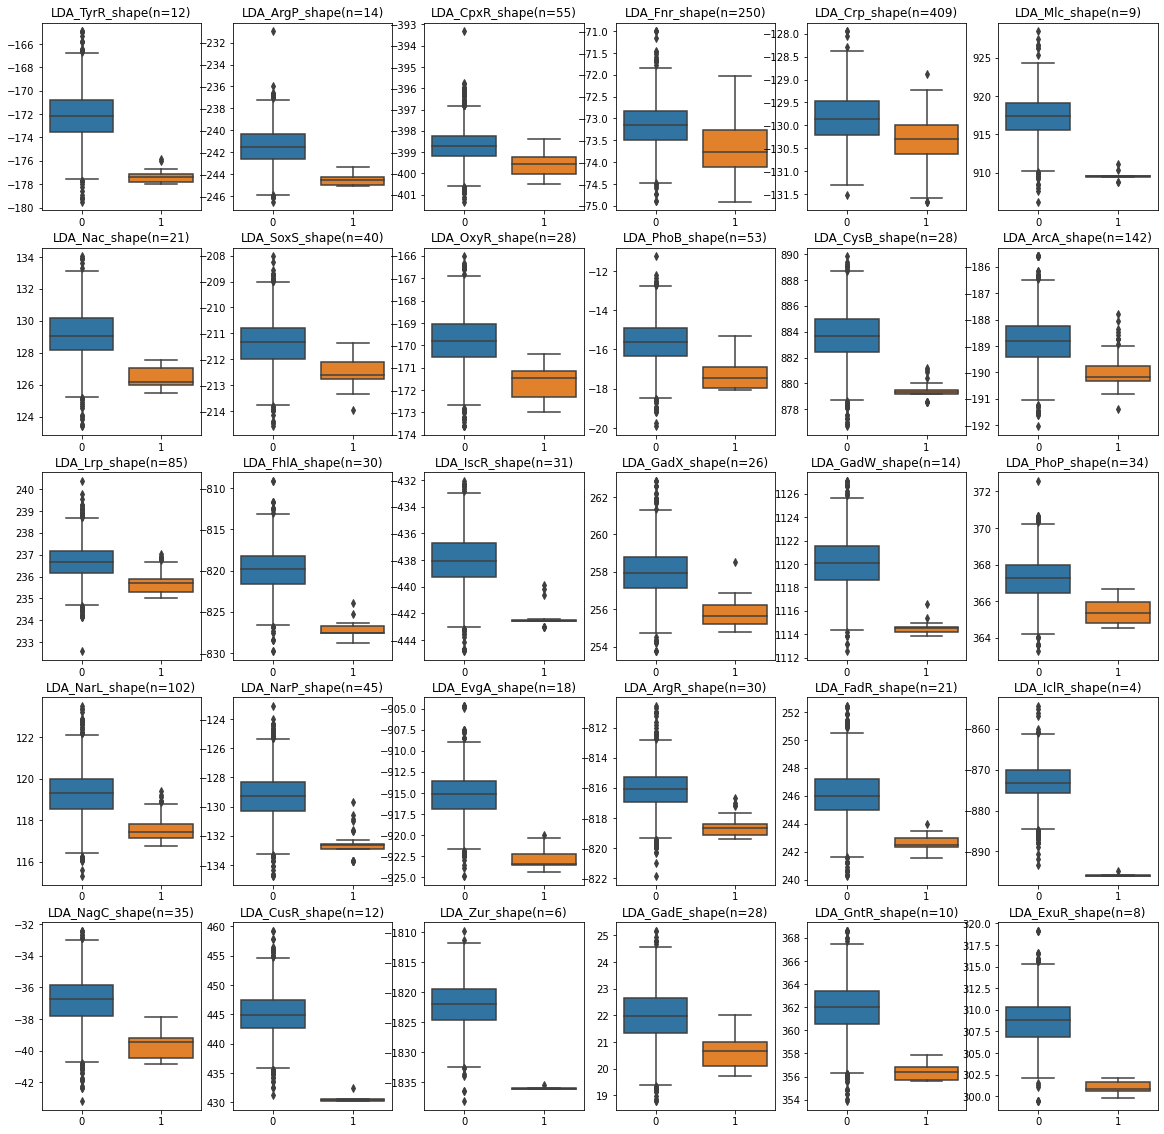

In [10]:
fig, axs = plt.subplots(5,6,figsize= (20,20))
for i in range(30):
    row_pos = int(i/6)
    col_pos = i - row_pos*6
    f_name = list( X_shape.keys() )[i]
    Xld = Xld_shape[f_name]
    if f_name == 'Crp':
        labels = list(regulon_labels['CRP'])
    elif f_name == 'Fnr':
        
        labels = list(regulon_labels['FNR'])
    else:
        labels = list(regulon_labels[f_name])
    
    sns.boxplot( labels,Xld, ax = axs[row_pos][col_pos] )
    axs[row_pos][col_pos].set_title('LDA_'+f_name+'_shape(n=' + str(sum(labels)) +')')


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

(0.0, 1.0, 0.0, 1.0)

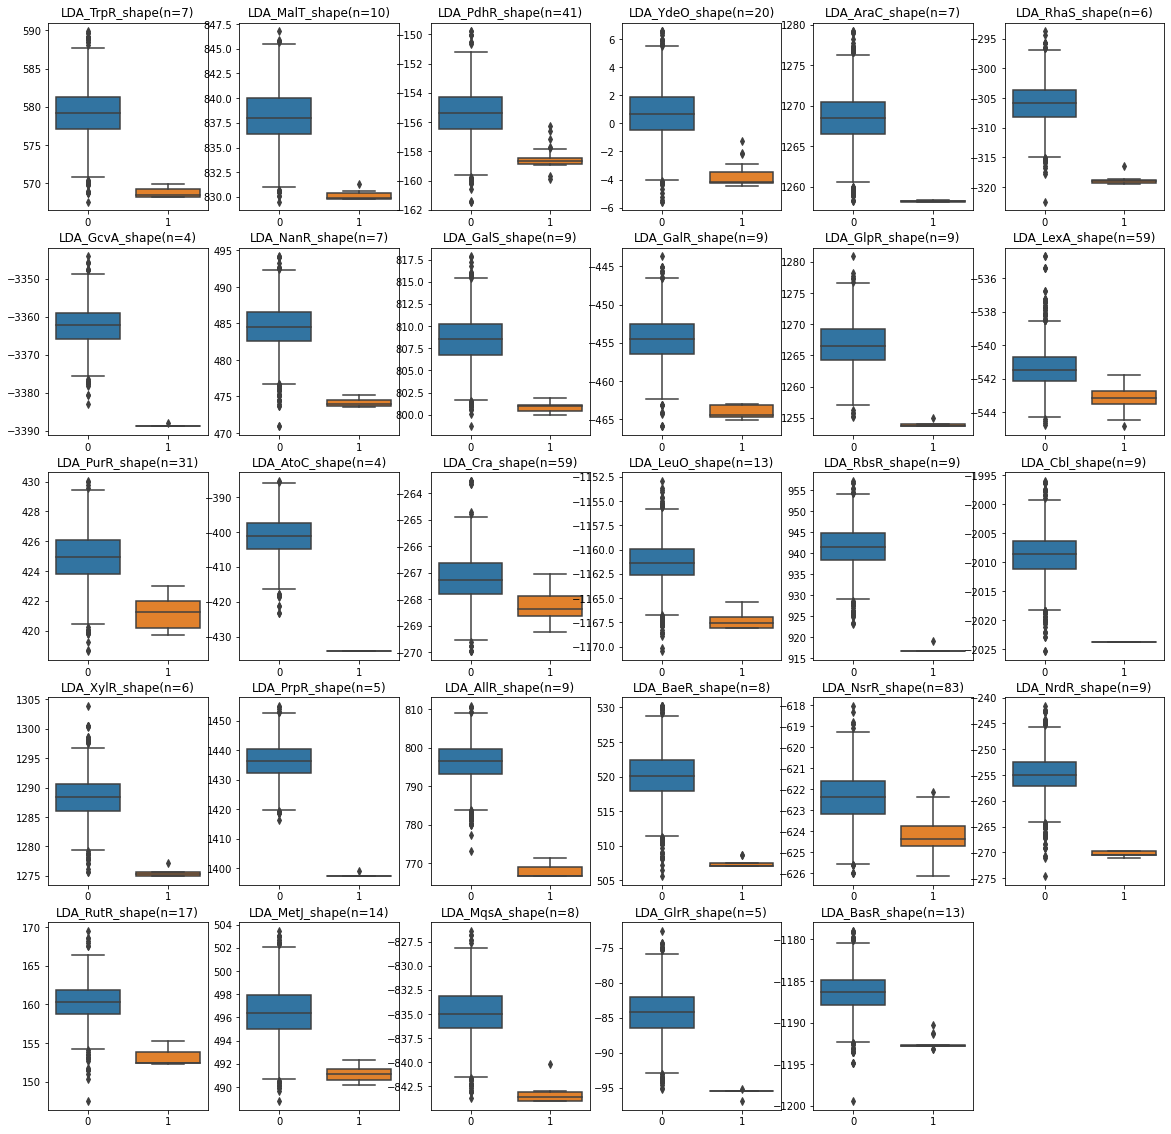

In [11]:
fig, axs = plt.subplots(5,6,figsize= (20,20))
for i in range(30,59):
    row_pos = int((i-30)/6)
    col_pos = (i-30) - row_pos*6
    f_name = list( X_shape.keys() )[i]
    Xld = Xld_shape[f_name]
    if f_name == 'Crp':
        labels = list(regulon_labels['CRP'])
    elif f_name == 'Fnr':
        
        labels = list(regulon_labels['FNR'])
    else:
        labels = list(regulon_labels[f_name])
    
    sns.boxplot( labels,Xld, ax = axs[row_pos][col_pos] )
    axs[row_pos][col_pos].set_title('LDA_'+f_name+'_shape(n=' + str(sum(labels)) +')')
    
axs[-1][-1].axis('off') 

## load sigma LDA and PSSM values to form a more concise table

In [12]:
eng_features = pd.DataFrame(Xld_shape)
eng_features.columns = [ n+'_shape_ld' for n in Xld_shape.keys()]

X_ld_sigma = {}

# [MODIFIED] Added Sigma19
# projection planes generated in Generate_SigmaFactor_PSSMs.ipynb
w_sigma = {'Sigma70': np.array([ 1.65064382e-02, -6.59506008e-02,  3.02672899e-01, -5.24886433e-02,
        1.71139291e-02, -5.81206469e-02,  1.50473443e-01, -6.07490918e-04,
       -6.33659058e-01,  1.83387202e-01]), 'Sigma38': np.array([-0.01371682, -0.20837012, -0.01447272, -0.08668739, -0.01633375,
        0.06734916, -0.07138144,  0.00261692, -0.543808  ,  0.58861234]), 'Sigma32': np.array([ 0.04611459, -0.27112878,  0.78284334, -0.03343359,  0.03332323,
       -0.13342375,  0.0499618 ,  0.01279136,  0.89601573, -1.3806742 ]), 'Sigma24': np.array([ 0.00797833, -0.11419877,  0.09339727, -0.06414143,  0.03343402,
       -0.16363185,  0.25952174, -0.02545569, -0.45804491,  0.98356359]), 'Sigma28': np.array([-0.03337679, -0.44776207,  0.83001936, -0.14254413,  0.0937775 ,
        0.02082157,  0.9029926 , -0.12715429, -5.67666246,  2.79836743]), 'Sigma54': np.array([ 0.00849921, -0.29833907,  0.19381744, -0.14867898, -0.1209861 ,
       -0.55674056,  0.08177916,  0.1294853 ,  2.10054191, -1.99187276]), 'Sigma19': np.array([  0.13900803,  -2.76955002,   3.99561608,  -0.30042426,
         0.21432894,  -1.49715869,   2.15994342,  -0.07532091,
       -15.24413734,  10.13575983])}

for signame in w_sigma.keys():
    temp = features[[signame + '_Prib_Start', signame + '_Prib_score',
       signame + '_Prib_hmd', signame + '_Prib_Tm', signame + '_m35_Start',
       signame + '_m35_score', signame +'_m35_hmd', signame +'_Spacer_Length',
       signame +'_Spacer_AT_ratio', signame + '_hepta_ratio']].iloc[:,:].values
    
    Xld_temp = []
    for v in temp:
        Xld_temp.append(  np.matmul( w_sigma[ signame ] , v) )
    X_ld_sigma[ signame ] = Xld_temp
    eng_features[signame + '_LD'] = Xld_temp
    
for r in motif_list:
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
        
    eng_features[f_name+' score'] = features[f_name+' score']

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

# 3. ML

In [13]:
X_eng = eng_features.iloc[:,:].values
X_eng = StandardScaler().fit_transform(X_eng)

# 2594 genes, 204 features
X_eng.shape

(2594, 200)

In [14]:
eng_features.set_index(features['ID'], inplace=True)
eng_features_stdd = pd.DataFrame(data = X_eng, columns=eng_features.columns)

In [15]:
# Grouping similar genes with potential same promoter (euclidean distance)

from scipy.stats import pearsonr

cluster_number = 0
cluster_list = ["Ungrouped"] * eng_features_stdd.shape[0]
start = 0
for ind1, row_A in eng_features_stdd.iterrows():
    start += 1
    if cluster_list[ind1] != "Ungrouped":
        continue
    
    cluster_number += 1
    cluster_list[ind1] = cluster_number
    for ind2, row_B in eng_features_stdd.iloc[start:,:].iterrows():
        
#         if cluster_list[ind1] != "Ungrouped":
#             continue
        # pearson correlation calculation
        corr, _ = pearsonr(row_A, row_B)
        if abs(corr) > 0.5 :
            cluster_list[ind2] = cluster_list[ind1]
#         elif: 
#             cluster_list[ind2] = "Ungrouped"         

In [16]:
# Grouping the genes in each iModulon according to similarity
search_cluster_df = pd.DataFrame(data=cluster_list, columns=['cluster'], index=eng_features.index)
IM_promoters = {}
for IM in IM_genes:
    gene_list = [gene for gene in IM_genes[IM] if gene in list(eng_features.index)]
    cluster_df = search_cluster_df.loc[gene_list, 'cluster'] 
    
    promoter_list = []
    for cluster_num in pd.unique(cluster_df):
        each_promoter_list = list(cluster_df[cluster_df==cluster_num].index)
        
        promoter_list.append(each_promoter_list)
    
    IM_promoters[IM] = promoter_list

In [17]:
# Grouping all genes

cluster_df = search_cluster_df['cluster'] 
All_promoters = []
for cluster_num in pd.unique(cluster_df):
    each_promoter_list = list(cluster_df[cluster_df==cluster_num].index)
    All_promoters.append(each_promoter_list)

In [18]:
All_promoters_df = pd.DataFrame(columns=['first_gene', 'genes'], index=range(len(All_promoters)))
ind = 0
for promoter in All_promoters:
    All_promoters_df.iloc[ind, 0] = promoter[0]
    All_promoters_df.iloc[ind, 1] = promoter
    ind += 1 
All_promoters_df.to_csv('../data/gene_groupby_promoter.csv')

In [19]:
import pickle
with open('../data/promoters_grouping_IM.pkl', 'wb') as f:
    pickle.dump(IM_promoters, f)
with open('../data/promoters_grouping_All.pkl', 'wb') as f:
    pickle.dump(All_promoters, f)

In [20]:
import pickle
with open('../data/promoters_grouping_IM.pkl', 'rb') as f:
    IM_promoters = pickle.load(f)
with open('../data/promoters_grouping_All.pkl', 'rb') as f:
    All_promoters = pickle.load(f)

In [21]:
eng_features_stdd = pd.DataFrame(data = X_eng, columns=eng_features.columns, index=eng_features.index)

In [22]:
eng_features_stdd.to_csv('../data/eng_features_stdd_table.csv')

In [23]:
exclude_IM_list = []
for IM in IM_promoters:
    if len(IM_promoters[IM]) == 0:
        print(IM, "doesn't contain any gene with a valid TSS")
        
        exclude_IM = IM
        exclude_IM_list.append(exclude_IM) 
    
    elif len(IM_promoters[IM]) == 1:
        print(IM, "only contain one promoter, excluded from LeaveOneOut")
        exclude_IM = IM
        exclude_IM_list.append(exclude_IM) 

CsqR doesn't contain any gene with a valid TSS
GlcC only contain one promoter, excluded from LeaveOneOut
GcvA only contain one promoter, excluded from LeaveOneOut
CecR only contain one promoter, excluded from LeaveOneOut
SrlR+GutM only contain one promoter, excluded from LeaveOneOut
NikR only contain one promoter, excluded from LeaveOneOut


In [24]:
# [MODIFIED]

models_to_try = {
    
#     'SVM': LinearSVC(
#     penalty = 'l1',
#     class_weight='balanced',
#     dual=False,
#     random_state=42,
#     verbose=0,
#     ),
    
    'LR': LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        class_weight='balanced',
        l1_ratio = 0.5,
        random_state=42
    )
    
#     'RF': RandomForestClassifier(
#         class_weight='balanced',
#         random_state=42,
#         verbose=0
#     )
}

## n-fold validation (resampling)

In [26]:
# need to downgrade numpy to version 1.21.4
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
import seaborn as sns

def resample_nfold(oversampler, num_neighbors=5, SMOTE_only = False, exact_repeats_boost=0.1,
                features_table=eng_features_stdd, target_labels=target_labels
                #, undersampler=None
                 ,  final_ratio=1, N_CV=5, random_state=4):
    '''
    oversampler: selected oversampling method from imblearn
    num_neighbor: Number of k-nearest neighbor used to perform SMOTE oversampling
    final_ratio: If undersample=True, the ratio of the n_negative_aftersampling to n_negative_beforesampling.
    
    '''
    
    result_df = pd.DataFrame(
        columns=['model', 'im', 'train_auc', 'test_auc']
    )

    for model_name, model in models_to_try.items():

        for IM_name, y_labels in target_labels.items():

            # skip the IMs that only contains one or zero group of genes
            if IM_name in exclude_IM_list:
                continue
                
            # skip the promoters that are too small
            if len(IM_promoters[IM_name])< N_CV:
                continue
            
            #index_num = 0
            print(f'{model_name}: {IM_name}')

            temp_eng_features = features_table.copy()
            temp_eng_features['label'] = y_labels        

            ingroup_set = IM_promoters[IM_name]
            outgroup_set = [l for l in All_promoters if not any(item in l for item in sum(IM_promoters[IM_name], [])) ]
            
#             random.Random(4).shuffle(outgroup_set) 
#             leave_one_out_set = ingroup_set + outgroup_set[:len(ingroup_set)]
#             pure_training_set = outgroup_set[len(ingroup_set):]

#            # only include unique samples in pure training set
#             pure_training_set = [l[0] for l in pure_training_set]

            kf = KFold(n_splits=N_CV)

            train_scores = []
            test_scores = []
            
            for (out_index, in_index) in zip(kf.split(outgroup_set), kf.split(ingroup_set)):

                # using sum here to flatten the list in list 
                test_promoters_out = sum([outgroup_set[i] for i in out_index[1]], [])          
                train_promoters_out = sum([outgroup_set[i] for i in out_index[0]], [])
                
                test_promoters_in = sum([ingroup_set[i] for i in in_index[1]], [])          
                train_promoters_in = sum([ingroup_set[i] for i in in_index[0]], [])
                
                test_promoters = test_promoters_out + test_promoters_in
                train_promoters = train_promoters_out + train_promoters_in
                
                train_X = temp_eng_features.loc[train_promoters].iloc[:, :-1]
                test_X = temp_eng_features.loc[test_promoters].iloc[:, :-1]

                train_Y = temp_eng_features.loc[train_promoters, 'label']
                test_Y = temp_eng_features.loc[test_promoters, 'label']
            
            
                if SMOTE_only == True:
                    # Only use RandomOverSampling to boost the samples number over num_neighbors+1
                    if len([l for l in train_Y if l==1])<=num_neighbors+1:
                        
                        exact_repeats_boost = (num_neighbors*2)/len([l for l in train_Y if l==0])                
                        rs = RandomOverSampler(sampling_strategy = exact_repeats_boost,random_state=random_state)
                        train_X, train_Y = rs.fit_resample(train_X, train_Y)
                    
                else:
                    # Use RandomOverSampling to boost the positive samples number to a certain pos/neg ratio.
                    rs = RandomOverSampler(sampling_strategy = exact_repeats_boost,random_state=random_state)
                    train_X, train_Y = rs.fit_resample(train_X, train_Y)             
                
                if exact_repeats_boost != 1:
                    # Oversampling by SMOTE
                    if oversampler == SMOTETomek:
                        over = oversampler(sampling_strategy = final_ratio, smote = SMOTE(k_neighbors = num_neighbors),
                                           random_state=random_state)
                        train_X, train_Y = over.fit_resample(train_X, train_Y)
                        
                    else:
                        over = oversampler(sampling_strategy = final_ratio, k_neighbors = num_neighbors,
                                           random_state=random_state)
                        train_X, train_Y = over.fit_resample(train_X, train_Y)
                    

#                 # undersampling by ClusterCentroids
#                 # undersample negative samples until the number of two classes are the same
                
#                 if undersampler!= None and final_ratio!=1:
#                     under = undersampler(sampling_strategy = 'majority') 
#                     train_X, train_Y = under.fit_sample(train_X, train_Y)      
                
                #print('size of training set', train_X.shape[0]) 
                
                model.fit(train_X, train_Y)

                if model_name == 'SVM':
                    train_auc = roc_auc_score(train_Y, model.decision_function(train_X))
                    test_auc = roc_auc_score(test_Y, model.decision_function(test_X))

                else:
                    train_auc = roc_auc_score(train_Y, model.predict_proba(train_X)[:,1])
                    test_auc = roc_auc_score(test_Y, model.predict_proba(test_X)[:,1])

                train_scores.append(train_auc)
                test_scores.append(test_auc)
                
                
            sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [IM_name] * N_CV,
                'train_auc': train_scores,
                'test_auc': test_scores
            }
            )

            # PCA evaluation of resampling
#             pca = PCA(2)
#             pca_data = pd.DataFrame(pca.fit_transform(train_X),columns=['PC1','PC2']) 
#             pca_data['label'] = train_Y
#             sns.scatterplot(x="PC1",y="PC2",hue="label", data=pca_data)
#             plt.title('After resampling for '+ IM_name)
#             plt.show()  

            #index_num += 1
            result_df = pd.concat([result_df,sub_result_df], axis=0)
        

    return result_df

In [28]:
result_large = resample_nfold(oversampler=SMOTETomek, SMOTE_only = True, num_neighbors=5, target_labels=target_labels, 
                              random_state=4)
#result_large.to_csv('../data/model_selection_shapeLD_precise1_5fold_AllSMOTETomek.csv')

LR: DhaR/Mlc


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArgR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: NarL


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: OxyR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Crp-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PurR-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: MetJ


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PurR-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Crp-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RpoH


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: GadEWX


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArcA-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Fnr


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Pyruvate


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: NagC/TyrR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: CpxR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Lrp


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Fur-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: CysB


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FliA


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: NtrC+RpoN


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RcsAB


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Fur-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: AllR/AraC/FucR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Cra


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArcA-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: EvgA


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Zinc


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: SoxS


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Nac


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Tryptophan


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FadR/IclR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FlhDC


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: GntR/TyrR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RpoS


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ExuR/FucR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [29]:
result_small = pd.DataFrame(
        columns=['model', 'im', 'train_auc', 'test_auc']
    )

for im in list(IM_promoters.keys()):
    if len(IM_promoters[im])>=5:
        continue
    else:
        fold = len(IM_promoters[im])
    
    temp_labels = {}
    temp_labels[im] = target_labels[im]
    result_temp = resample_nfold(oversampler=SMOTETomek, features_table=eng_features_stdd, SMOTE_only = True, num_neighbors=5, N_CV=fold, target_labels=temp_labels,
                                random_state=0)
    
    #print(result_temp)
    result_small = pd.concat([result_small, result_temp],axis=0)

LR: GlpR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: MalT


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: AtoC


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Cbl+CysB


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: YiaJ


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: XylR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PrpR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: GadWX


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: CdaR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Leu/Ile


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Thiamine


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PuuR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: His-tRNA


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Copper


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FecI


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RbsR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [30]:
result_all = pd.concat([result_large,result_small],axis=0)
result_all.to_csv('../data/model_selection_shapeLD_precise1_nfold_SMOTETomek.csv')

Text(0.5, 0, 'ICA Regulons')

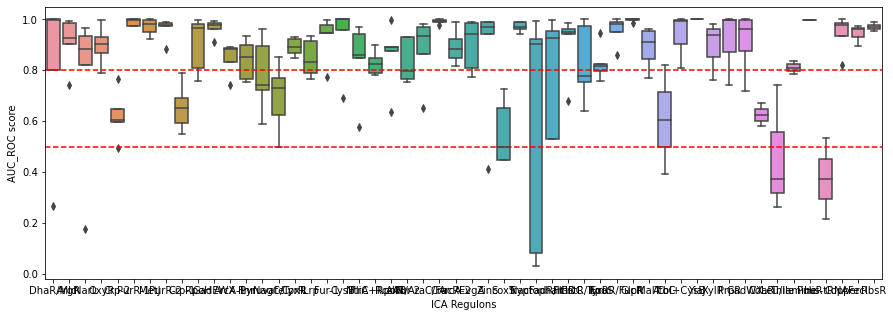

In [31]:
# n-fold

result_LR = result_all[result_all['model']=='LR']
plt.figure( figsize=(15,5))
sns.boxplot(x='im', y='test_auc', data=result_LR)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
# plt.title('LR motif only vs feature engineered')
# plt.xlim([2.5,11.5])
# plt.ylim([0.0,1.05])
plt.ylabel('AUC_ROC score')

plt.xlabel('ICA Regulons')

In [32]:
# result_df = pd.read_csv('../data/model_selection_shapeLD_precise1_nfold_SMOTETomek.csv', index_col=0)
# SVM_list = []
# for IM in IM_promoters:
# #     if len(IM_promoters[IM])<5:
# #         continue
#     temp_df = result_df[result_df['im']==IM].copy()
#     if temp_df[temp_df['model']=='SVM']['test_auc'].mean() > + temp_df[temp_df['model']=='LR']['test_auc'].mean():
#         SVM_list.append(IM)

# print(SVM_list)

# 4. Feature importances

In [35]:
# [MODIFIED]
# Evaluat on the entire set
def shap_SMOTETomek(features_table, path, suffix, target_labels=target_labels, random_state=4):
    
    final_ratio=1
    num_neighbors=5
    # exact_repeats_boost=0.1
    # oversampler=SMOTETomek

    for IM_name, y_labels in target_labels.items():
        print(IM_name)    
        # skip the IMs that only contains one or zero group of genes
        if IM_name in exclude_IM_list:
            continue

        X = features_table
        y = y_labels

        # Only use RandomOverSampling to boost the samples number over num_neighbors+1
        if len([l for l in y if l==1])<=num_neighbors:

            exact_repeats_boost = (num_neighbors+1)/len([l for l in y if l==0])                
            rs = RandomOverSampler(sampling_strategy = exact_repeats_boost, random_state=random_state)
            X, y = rs.fit_resample(X, y)

        over = SMOTETomek(sampling_strategy = final_ratio, smote = SMOTE(k_neighbors = num_neighbors),
                          random_state=random_state)
        X, y = over.fit_resample(X, y)

        clf = models_to_try['LR']  

        clf.fit(X, y)
        explainer = shap.Explainer(clf, X)
        shap_vals = explainer(X)

        shap.plots.beeswarm(copy.deepcopy(shap_vals), max_display=6, show = False)
        IM_name = IM_name.replace('/','_')
        plt.savefig(path + str(IM_name) + suffix, bbox_inches='tight')
        plt.close()
        plt.cla()
        plt.clf()

In [36]:
shap_SMOTETomek(features_table=eng_features_stdd, path='../data/feature_importance/', suffix = '_SMOTE_alldata', target_labels=target_labels)

GlpR


The max_iter was reached which means the coef_ did not converge


DhaR/Mlc


The max_iter was reached which means the coef_ did not converge


ArgR


The max_iter was reached which means the coef_ did not converge


NarL


The max_iter was reached which means the coef_ did not converge


MalT


The max_iter was reached which means the coef_ did not converge


OxyR


The max_iter was reached which means the coef_ did not converge


Crp-2


The max_iter was reached which means the coef_ did not converge


AtoC


The max_iter was reached which means the coef_ did not converge


PurR-1


The max_iter was reached which means the coef_ did not converge


CsqR
MetJ


The max_iter was reached which means the coef_ did not converge


PurR-2


The max_iter was reached which means the coef_ did not converge


Cbl+CysB


The max_iter was reached which means the coef_ did not converge


GlcC
Crp-1


The max_iter was reached which means the coef_ did not converge


YiaJ


The max_iter was reached which means the coef_ did not converge


GcvA
XylR


The max_iter was reached which means the coef_ did not converge


RpoH


The max_iter was reached which means the coef_ did not converge


GadEWX


The max_iter was reached which means the coef_ did not converge


PrpR


The max_iter was reached which means the coef_ did not converge


GadWX


The max_iter was reached which means the coef_ did not converge


CecR
ArcA-1


The max_iter was reached which means the coef_ did not converge


Fnr


The max_iter was reached which means the coef_ did not converge


CdaR


The max_iter was reached which means the coef_ did not converge


Pyruvate


The max_iter was reached which means the coef_ did not converge


SrlR+GutM
NagC/TyrR


The max_iter was reached which means the coef_ did not converge


CpxR


The max_iter was reached which means the coef_ did not converge


Lrp


The max_iter was reached which means the coef_ did not converge


Leu/Ile


The max_iter was reached which means the coef_ did not converge


Fur-1


The max_iter was reached which means the coef_ did not converge


Thiamine


The max_iter was reached which means the coef_ did not converge


CysB


The max_iter was reached which means the coef_ did not converge


FliA


The max_iter was reached which means the coef_ did not converge


PuuR


The max_iter was reached which means the coef_ did not converge


NikR
NtrC+RpoN


The max_iter was reached which means the coef_ did not converge


RcsAB


The max_iter was reached which means the coef_ did not converge


His-tRNA


The max_iter was reached which means the coef_ did not converge


Fur-2


The max_iter was reached which means the coef_ did not converge


Copper


The max_iter was reached which means the coef_ did not converge


AllR/AraC/FucR


The max_iter was reached which means the coef_ did not converge


Cra


The max_iter was reached which means the coef_ did not converge


ArcA-2


The max_iter was reached which means the coef_ did not converge


EvgA


The max_iter was reached which means the coef_ did not converge


Zinc


The max_iter was reached which means the coef_ did not converge


SoxS


The max_iter was reached which means the coef_ did not converge


Nac


The max_iter was reached which means the coef_ did not converge


Tryptophan


The max_iter was reached which means the coef_ did not converge


FadR/IclR


The max_iter was reached which means the coef_ did not converge


FlhDC


The max_iter was reached which means the coef_ did not converge


GntR/TyrR


The max_iter was reached which means the coef_ did not converge


RpoS


The max_iter was reached which means the coef_ did not converge


ExuR/FucR


The max_iter was reached which means the coef_ did not converge


FecI


The max_iter was reached which means the coef_ did not converge


RbsR


The max_iter was reached which means the coef_ did not converge


<Figure size 432x288 with 0 Axes>

### ArgR

In [37]:
result_all = pd.read_csv('../data/model_selection_shapeLD_precise1_nfold_SMOTETomek.csv', index_col=0)
result_motif = pd.read_csv('../data/model_selection_MotifOnly_precise1_nfold_SMOTETomek.csv', index_col=0)

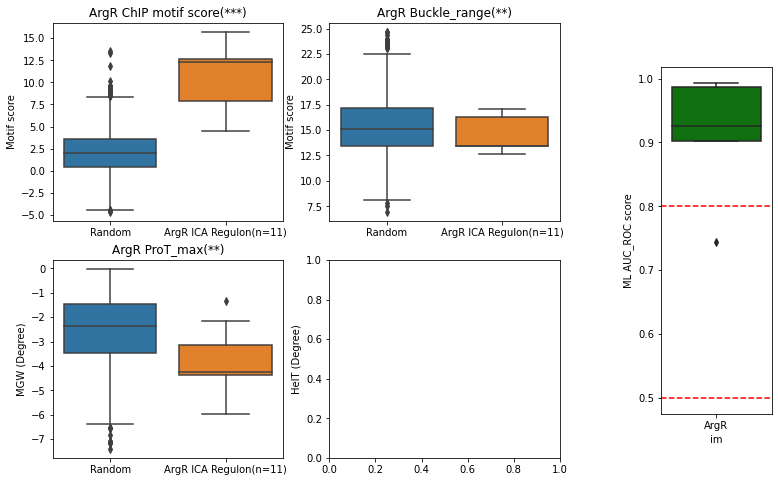

In [39]:
# [MODIFIED]
import matplotlib.gridspec as gridspec
y_to_try = {
    'ArgR':target_labels['ArgR'], 'Lrp': target_labels['Lrp']
}

f = plt.figure(figsize=(20,8))
gs0 = gridspec.GridSpec(1, 2)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
ax1 = plt.Subplot(f, gs00[0, 0])
f.add_subplot(ax1)
ax2 = plt.Subplot(f, gs00[0, 1])
f.add_subplot(ax2)
ax3 = plt.Subplot(f, gs00[1, 0])
f.add_subplot(ax3)
ax4 = plt.Subplot(f, gs00[1, 1])
f.add_subplot(ax4)

axs = [ax1,ax2,ax3,ax4]

gs01 = gridspec.GridSpecFromSubplotSpec(10, 4, subplot_spec=gs0[1])

ax5 = plt.Subplot(f, gs01[1:9, :-3])
f.add_subplot(ax5)


#f.tight_layout()


#fig,axs = plt.subplots(2,2,figsize=(12,12))
what_to_plot = ['ArgR score',
                #'ArgR score',
                'ArgR Buckle_range','ArgR ProT_max']
for i in range(len(what_to_plot) ):
    #temp_ax = axs[int(i/2)][int(i%2)]
    temp_ax = axs[i]
    sns.boxplot( x= y_to_try['ArgR'],y=features[what_to_plot[i]],ax=temp_ax )
    temp_ax.set_xticklabels(['Random','ArgR ICA Regulon(n={num})'.format(num=sum(y_to_try['ArgR']))])
    temp_ax.set_title(what_to_plot[i]+'(**)')

plot_df = result_all[result_all['im']=='ArgR'].copy()

sns.boxplot(x= plot_df['im'], y= plot_df['test_auc'], ax=ax5, color='g')

plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')

ax1.set_title("ArgR ChIP motif score(***)")
#ax2.set_title("ArgR I-Modulon motif score(***)")
ax1.set_ylabel("Motif score")
ax2.set_ylabel('Motif score')
ax3.set_ylabel('MGW (Degree)')
ax4.set_ylabel('HelT (Degree)')
ax5.set_ylabel('ML AUC_ROC score')

f.savefig('../data/Figures/ArgR_boxplot.pdf',dpi=150)

In [40]:
col_shape = []
for col in features.columns:
    if any(x in col for x in ['max', 'avg', 'range']) and any(x in col for x in ['ArgR', 'Lrp']) and ('im' in col):
        col_shape.append(col)

features_temp = features.set_index(features['ID'], inplace=False)
features_temp = features_temp.iloc[:, 6:].copy()
features_temp = features_temp[col_shape]
for IM in y_to_try.keys():
    if IM == 'ArgR':
        continue
    features_temp['label'] = y_to_try[IM]
    diff = abs(features_temp[features_temp['label']==1].mean() - features_temp[features_temp['label']==0].mean())
    #print(IM, diff.sort_values(ascending=False))

### RpoH(Sigma32)

In [41]:
# [MODIFIED]

# f = plt.figure(figsize=(20,8))
# gs0 = gridspec.GridSpec(1, 2)

# gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
# ax1 = plt.Subplot(f, gs00[0, 0])
# f.add_subplot(ax1)
# ax2 = plt.Subplot(f, gs00[0, 1])
# f.add_subplot(ax2)
# ax3 = plt.Subplot(f, gs00[1, 0])
# f.add_subplot(ax3)
# ax4 = plt.Subplot(f, gs00[1, 1])
# f.add_subplot(ax4)

# axs = [ax1,ax2,ax3,ax4]

# gs01 = gridspec.GridSpecFromSubplotSpec(10, 4, subplot_spec=gs0[1])

# ax5 = plt.Subplot(f, gs01[1:9, :-3])
# f.add_subplot(ax5)


# #f.tight_layout()


# #fig,axs = plt.subplots(2,2,figsize=(12,12))


# sns.boxplot( x= y_to_try['RpoH'],y=features['Sigma32_Prib_score'],ax=ax1)
# sns.boxplot( x= y_to_try['RpoH'],y=features['Sigma32_m35_score'],ax=ax2 )
# sns.boxplot( x= y_to_try['RpoH'],y=features['Sigma32_Prib_hmd'],ax=ax3 )
# sns.boxplot( x= y_to_try['RpoH'],y=features['Sigma32_m35_hmd'],ax=ax4 )
# for ax in axs:
#     ax.set_xticklabels(['Random','RpoH ICA Regulon(n={num})'.format(num=sum(y_to_try['RpoH']))])
        
# ax1.set_title("Sigma32 -10_box motif score(***)")
# ax1.set_ylabel("Motif score")
# ax2.set_title("Sigma32 -35_box motif score(***)")
# ax2.set_ylabel("Motif score")
# ax3.set_title("Sigma32 -10_box hamming distance(***)")
# ax3.set_ylabel("Hamming distance")
# ax4.set_title("Sigma32 -35_box hamming distance(***)")
# ax4.set_ylabel("Hamming distance")


# plot_df = result_all[result_all['im']=='RpoH'].copy()

# sns.boxplot(x= plot_df['im'], y= plot_df['test_auc'], ax=ax5, color='g')

# plt.axhline(y= 0.5, color = 'r', ls = '--')
# plt.axhline(y= 0.8, color = 'r', ls = '--')
# ax5.set_ylabel('ML AUC_ROC score')


# f.savefig('../data/Figures/RpoH_boxplot.pdf',dpi=150)

### EvgA

In [42]:
# [MODIFIED]

# f = plt.figure(figsize=(20,8))
# gs0 = gridspec.GridSpec(1, 2)

# gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
# ax1 = plt.Subplot(f, gs00[0, 0])
# f.add_subplot(ax1)
# ax2 = plt.Subplot(f, gs00[0, 1])
# f.add_subplot(ax2)
# ax3 = plt.Subplot(f, gs00[1, 0])
# f.add_subplot(ax3)
# ax4 = plt.Subplot(f, gs00[1, 1])
# f.add_subplot(ax4)

# axs = [ax1,ax2,ax3,ax4]

# gs01 = gridspec.GridSpecFromSubplotSpec(10, 4, subplot_spec=gs0[1])

# ax5 = plt.Subplot(f, gs01[1:9, :-3])
# f.add_subplot(ax5)


# #f.tight_layout()


# #fig,axs = plt.subplots(2,2,figsize=(12,12))
# what_to_plot = ['EvgA score','EvgA im score','EvgA ProT_avg','EvgA Roll_max']
# for i in range(len(what_to_plot) ):
#     #temp_ax = axs[int(i/2)][int(i%2)]
#     temp_ax = axs[i]
#     sns.boxplot( x= y_to_try['EvgA'],y=features[what_to_plot[i]],ax=temp_ax )
#     temp_ax.set_xticklabels(['Random','EvgA ICA Regulon(n={num})'.format(num=sum(y_to_try['EvgA']))])
#     temp_ax.set_title(what_to_plot[i]+'(**)')

# plot_df = result_all[result_all['im']=='EvgA'].copy()

# sns.boxplot(x= plot_df['im'], y= plot_df['test_auc'], ax=ax5, color='g')

# plt.axhline(y= 0.5, color = 'r', ls = '--')
# plt.axhline(y= 0.8, color = 'r', ls = '--')

# ax1.set_title("EvgA ChIP motif score(***)")
# ax2.set_title("EvgA I-Modulon motif score(***)")
# ax1.set_ylabel("Motif score")
# ax2.set_ylabel('Motif score')
# ax3.set_ylabel('ProT (Degree)')
# ax4.set_ylabel('Roll (Degree)')
# ax5.set_ylabel('ML AUC_ROC score')

# f.savefig('../data/Figures/EvgA_boxplot.pdf',dpi=150)

## Lrp

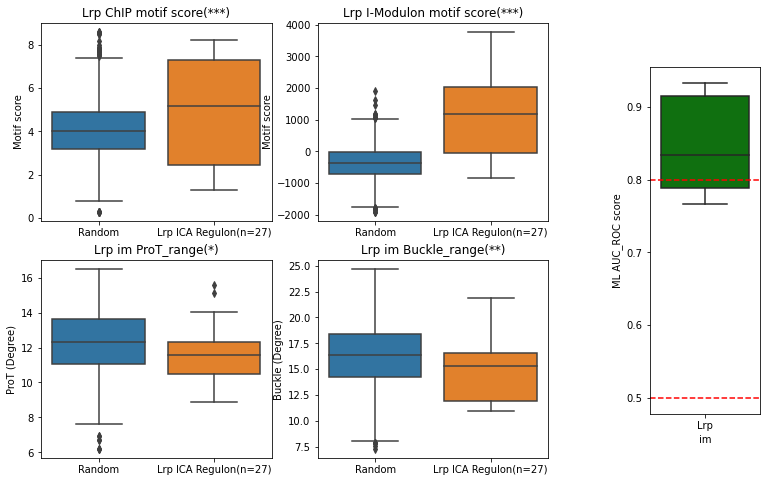

In [43]:
# [MODIFIED]

f = plt.figure(figsize=(20,8))
gs0 = gridspec.GridSpec(1, 2)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])
ax1 = plt.Subplot(f, gs00[0, 0])
f.add_subplot(ax1)
ax2 = plt.Subplot(f, gs00[0, 1])
f.add_subplot(ax2)
ax3 = plt.Subplot(f, gs00[1, 0])
f.add_subplot(ax3)
ax4 = plt.Subplot(f, gs00[1, 1])
f.add_subplot(ax4)

axs = [ax1,ax2,ax3,ax4]

gs01 = gridspec.GridSpecFromSubplotSpec(10, 4, subplot_spec=gs0[1])

ax5 = plt.Subplot(f, gs01[1:9, :-3])
f.add_subplot(ax5)


#f.tight_layout()


#fig,axs = plt.subplots(2,2,figsize=(12,12))
what_to_plot = ['Lrp score','Lrp im score',
                'Lrp im ProT_range','Lrp im Buckle_range'
               #'Lrp im_shape_ld'
               ]
for i in range(len(what_to_plot) ):
    #temp_ax = axs[int(i/2)][int(i%2)]
    temp_ax = axs[i]
    sns.boxplot( x= y_to_try['Lrp'],y=features[what_to_plot[i]],ax=temp_ax )
    temp_ax.set_xticklabels(['Random','Lrp ICA Regulon(n={num})'.format(num=sum(y_to_try['Lrp']))])
    if i ==2:
        temp_ax.set_title(what_to_plot[i]+'(*)')
    if i ==3:
        temp_ax.set_title(what_to_plot[i]+'(**)')

plot_df = result_all[result_all['im']=='Lrp'].copy()

sns.boxplot(x= plot_df['im'], y= plot_df['test_auc'], ax=ax5, color='g')

plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')

ax1.set_title("Lrp ChIP motif score(***)")
ax2.set_title("Lrp I-Modulon motif score(***)")
ax1.set_ylabel("Motif score")
ax2.set_ylabel('Motif score')
ax3.set_ylabel('ProT (Degree)')
ax4.set_ylabel('Buckle (Degree)')
ax5.set_ylabel('ML AUC_ROC score')

f.savefig('../data/Figures/Lrp_boxplot.pdf',dpi=150)

# 5. Comparison of I-Modulons and ChIP regulons

In [44]:
import random

# [MODIFIED] change IMs_to_check to precise1

IMs_to_check = ['ArgR','Cra','EvgA','NarL','CysB']
data = {}
for im in IMs_to_check:
    data[im] = {'category':[],'score':[]}
    if im in ['CysB-1','CysB-2']:
        chip_name = im[0:4]
    else:
        chip_name = im
        
    for i in range(len(ID)):
        if ID[i] in set(regulon_genes[chip_name])&set(IM_genes[im]):
            data[im]['category'].append( 'Overlap')
            data[im]['score'].append( eng_features[ chip_name+' score'][i])
        if ID[i] in set(IM_genes[im]) - set(regulon_genes[chip_name]):
            data[im]['category'].append( 'ICA_Regulon(unique)')
            data[im]['score'].append( eng_features[ chip_name+' score'][i])
        if ID[i] in set(regulon_genes[chip_name]) - set(IM_genes[im]):
            data[im]['category'].append( 'ChIP_Regulon(unique)')
            data[im]['score'].append( eng_features[ chip_name+' score'][i])
            
    
    for j in range(200):
        rand_index = random.randint(100,2000)
        data[im]['category'].append( 'Random')
        data[im]['score'].append( eng_features[ chip_name +' score'][ rand_index ])        

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

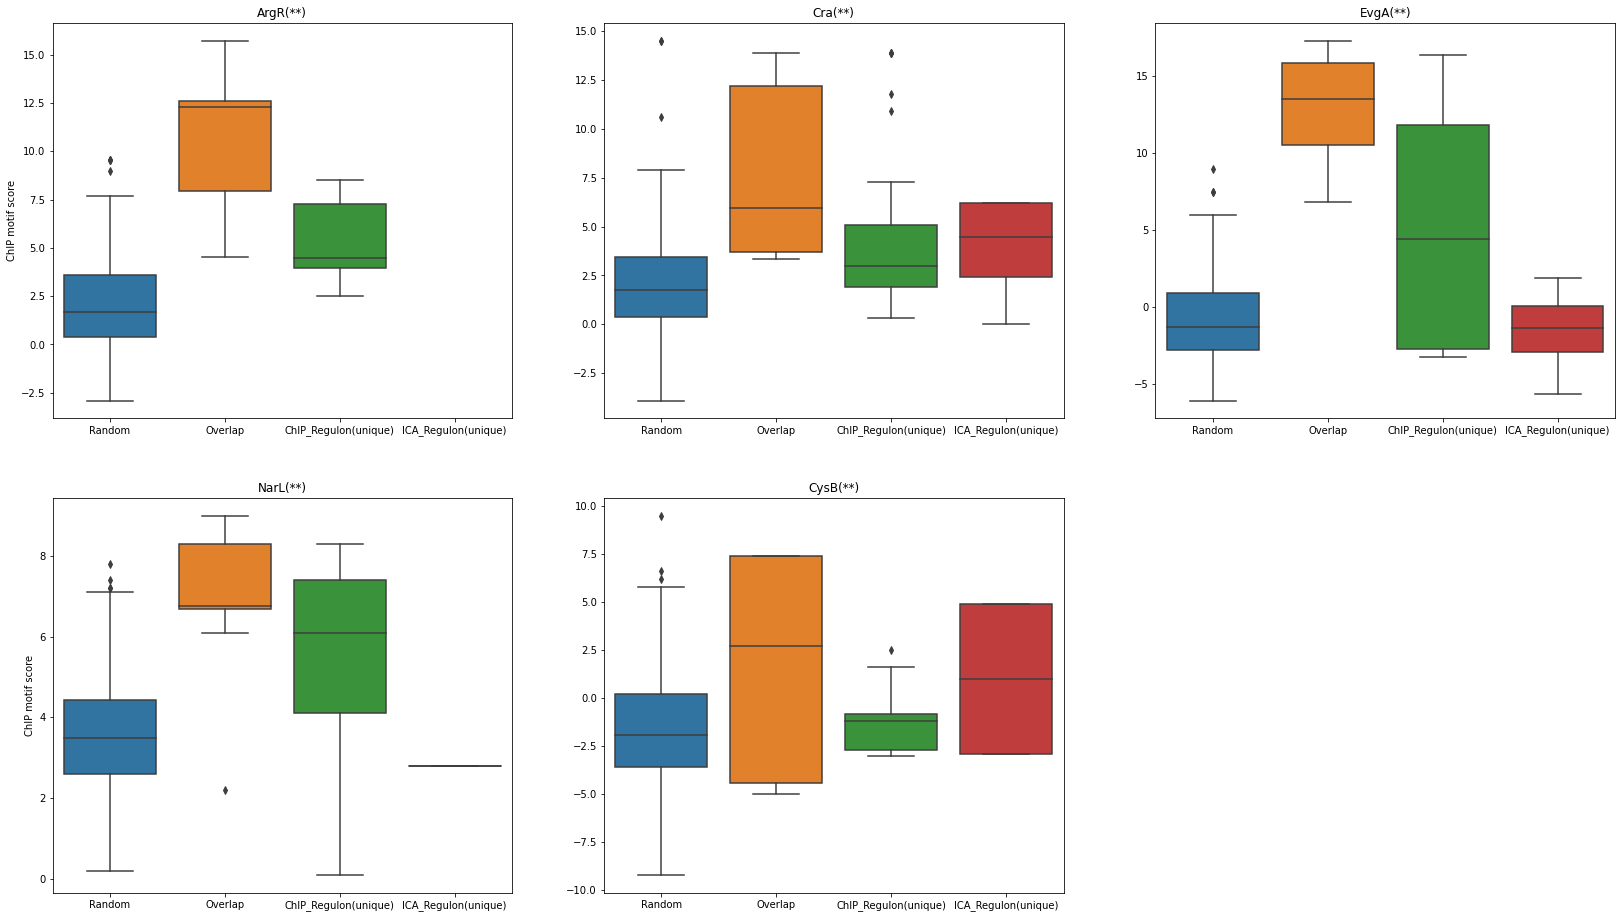

In [45]:
fig, axs = plt.subplots(2,3,figsize=(28,16))
for i in range(5):
    x_axis = i%3
    y_axis = int( i/3 )
    im = IMs_to_check[i]
    sub_data  = data [ IMs_to_check[i] ]
    category = sub_data['category']
    score = sub_data['score']
    sns.boxplot( category, score , ax = axs[y_axis][x_axis], 
                order = ['Random','Overlap','ChIP_Regulon(unique)','ICA_Regulon(unique)'] );
    axs[y_axis][x_axis].set_title(IMs_to_check[i]+"(**)")
    if x_axis == 0:
        axs[y_axis][x_axis].set_ylabel('ChIP motif score')
axs[-1][-1].axis('off') 
fig.savefig('../data/Figures/TRN_comp_score.pdf',dpi=150)

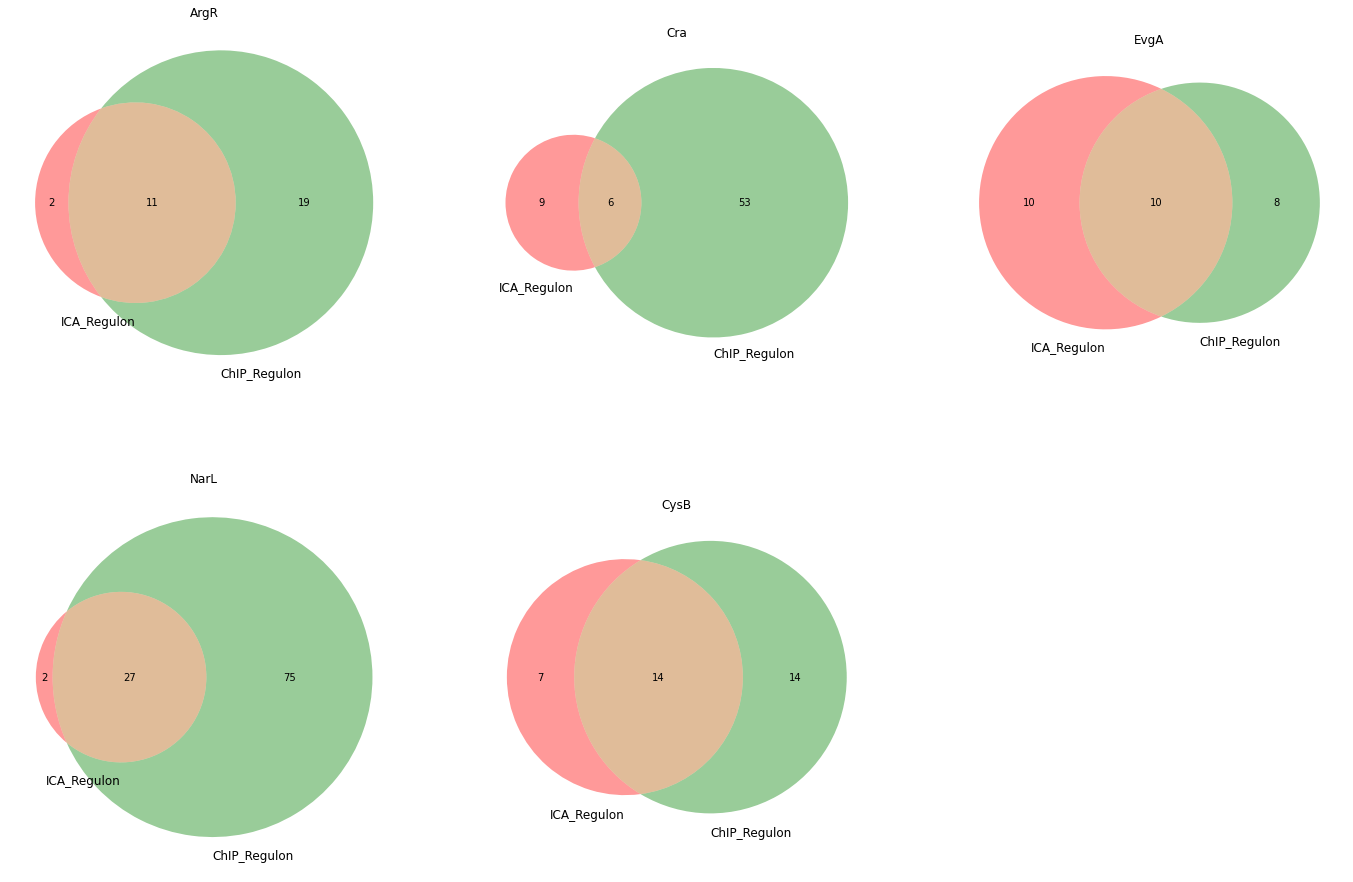

In [46]:
from matplotlib_venn import venn2
fig, axs = plt.subplots(2,3,figsize=(24,16))
for i in range(5):
    x_axis = i%3
    y_axis = int( i/3 )
    im = IMs_to_check[i]

    venn2([set(IM_genes[im]),set(regulon_genes[im])],set_labels = ('ICA_Regulon','ChIP_Regulon'), 
          ax = axs[y_axis][x_axis])
        
    axs[y_axis][x_axis].set_title(im)
    
axs[-1][-1].axis('off') 

fig.savefig('../data/Figures/venn.pdf',dpi=150)

# 6. Assess  different data sets performance: before and after feature engineering

This part is before feature engineering (direcly using feature table without doing IDA). The previous parts are after feature engineering.

In [47]:
TF_scores = pd.DataFrame()
for r in regulon_genes.keys():
    f_name = r
    if f_name == 'FNR':
        f_name = 'Fnr'
    if f_name == 'CRP':
        f_name = 'Crp'
        
    TF_scores[f_name+' score'] = features[f_name+' score']

X_chip = TF_scores.iloc[:,:].values
X_chip = StandardScaler().fit_transform(X_chip)
X_chip_df = pd.DataFrame(X_chip, columns=TF_scores.columns, index=features['ID'])

In [48]:
X_chip_df.to_csv('../data/motif_only_table.csv')

In [49]:
result_large = resample_nfold(oversampler=SMOTETomek, features_table=X_chip_df, SMOTE_only=True, target_labels=target_labels,
                             random_state=0)

LR: DhaR/Mlc


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArgR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: NarL


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: OxyR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Crp-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PurR-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: MetJ


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PurR-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Crp-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RpoH


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: GadEWX


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArcA-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Fnr


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Pyruvate


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: NagC/TyrR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: CpxR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Lrp


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Fur-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: CysB


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FliA


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: NtrC+RpoN


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RcsAB


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Fur-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: AllR/AraC/FucR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Cra


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArcA-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: EvgA


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Zinc


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: SoxS


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Nac


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Tryptophan


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FadR/IclR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FlhDC


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: GntR/TyrR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RpoS
LR: ExuR/FucR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [50]:
# [MODIFIED]
result_small = pd.DataFrame(
        columns=['model', 'im', 'train_auc', 'test_auc']
    )

for im in list(IM_promoters.keys()):
    if len(IM_promoters[im])>=5:
        continue
    else:
        fold = len(IM_promoters[im])
    
    temp_labels = {}
    temp_labels[im] = target_labels[im]
    result_temp = resample_nfold(oversampler=SMOTETomek, features_table=X_chip_df, SMOTE_only = True, num_neighbors=5, N_CV=fold, target_labels=temp_labels,
                                random_state=0)
    
    #print(result_temp)
    result_small = pd.concat([result_small, result_temp],axis=0)            

LR: GlpR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: MalT


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: AtoC


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Cbl+CysB


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: YiaJ


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: XylR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PrpR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: GadWX


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: CdaR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Leu/Ile


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Thiamine


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: PuuR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: His-tRNA


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: Copper


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: FecI


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: RbsR


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [51]:
result_motif = pd.concat([result_large, result_small],axis=0)
result_motif.to_csv('../data/model_selection_MotifOnly_precise1_nfold_SMOTETomek.csv')

In [52]:
result_motif = pd.read_csv('../data/model_selection_MotifOnly_precise1_nfold_SMOTETomek.csv', index_col=0)
result_all = pd.read_csv('../data/model_selection_shapeLD_precise1_nfold_SMOTETomek.csv', index_col=0)
result_motif = result_motif[result_motif['model']=='LR']
result_all = result_all[result_all['model']=='LR']

In [53]:
im_improved = []
im_big_improved = []
good_list = []
im_no_improved = []
im_not_save = []
motif_enough_list = []

for im in IM_promoters:
    if im in exclude_IM_list:
        continue

    if np.median(result_all[result_all['im']==im]['test_auc'])>np.median(result_motif[result_motif['im']==im]['test_auc']):
        im_improved.append(im)
    if np.median(result_all[result_all['im']==im]['test_auc'])>(np.median(result_motif[result_motif['im']==im]['test_auc']) + 0.2):
        im_big_improved.append(im)
    if np.median(result_all[result_all['im']==im]['test_auc'])<=0.05+(np.median(result_motif[result_motif['im']==im]['test_auc'])):
        im_no_improved.append(im)
    if np.median(result_all[result_all['im']==im]['test_auc'])>0.8:
        good_list.append(im)
    if np.median(result_motif[result_motif['im']==im]['test_auc'])>0.8:
        motif_enough_list.append(im)
    if (np.median(result_motif[result_motif['im']==im]['test_auc'])<0.8) and (np.median(result_all[result_all['im']==im]['test_auc'])<0.8):
        im_not_save.append(im)
    
#     if mean(result_motif[result_motif['im']==im]['test_auc'])>0.8:
#         print(im, mean(result_motif[result_motif['im']==im]['test_auc']))

# print("%s of large models have auc score improved after feature engineering with 5v" % f"{(len(im_improved)/len(im_list) ):.0%}")
# print("%s of large models have auc score larger than 0.8 after feature engineering with 5v" % f"{(len(good_list)/len(im_list) ):.0%}")


In [54]:
# temp = eng_features_stdd.copy()
# for im in ['NarL', 'DhaR/Mlc', 'OxyR', 'Fur-2', 'GntR/TyrR']:
#     for i in eng_features_stdd.columns:
#         if im + ' im' in i:
#             #print(i)
#             temp = temp.drop([i], axis=1)

In [55]:
# result_temp = resample_nfold(oversampler=SMOTETomek, features_table=temp, SMOTE_only=True, target_labels=target_labels,
#                              random_state=0)

In [56]:
# result_small_temp = pd.DataFrame(
#         columns=['model', 'im', 'train_auc', 'test_auc']
#     )

# for im in list(IM_promoters.keys()):
#     if len(IM_promoters[im])>=5:
#         continue
#     else:
#         fold = len(IM_promoters[im])
    
#     temp_labels = {}
#     temp_labels[im] = target_labels[im]
#     result_temp_temp = resample_nfold(oversampler=SMOTETomek, features_table=temp, SMOTE_only = True, num_neighbors=5, N_CV=fold, target_labels=temp_labels,
#                                 random_state=0)
    
#     #print(result_temp)
#     result_small_temp = pd.concat([result_small_temp, result_temp_temp],axis=0)
    
# result_all_temp = pd.concat([result_temp, result_small_temp],axis=0)

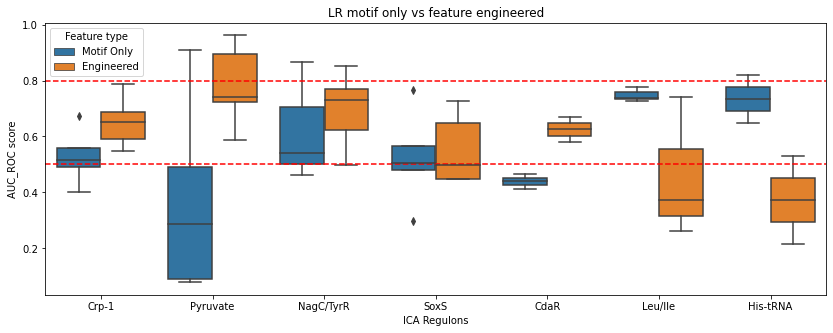

In [57]:
plot_motif = result_motif[result_motif['im'].isin(im_not_save)].copy()
plot_all = result_all[result_all['im'].isin(im_not_save)].copy()
plot_all['Feature type'] = ['Engineered']*plot_all.shape[0]
plot_motif['Feature type'] = ['Motif Only']*plot_motif.shape[0]

plot_df = pd.concat([plot_motif, plot_all],axis=0)


plt.figure( figsize=(14,5))
sns.boxplot(x='im', y='test_auc', hue="Feature type", data=plot_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.title('LR motif only vs feature engineered')
# plt.xlim([2.5,11.5])
# plt.ylim([0.0,1.05])
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')

plt.savefig('../data/Figures/5fold_IMnotSave_boxplot.pdf')

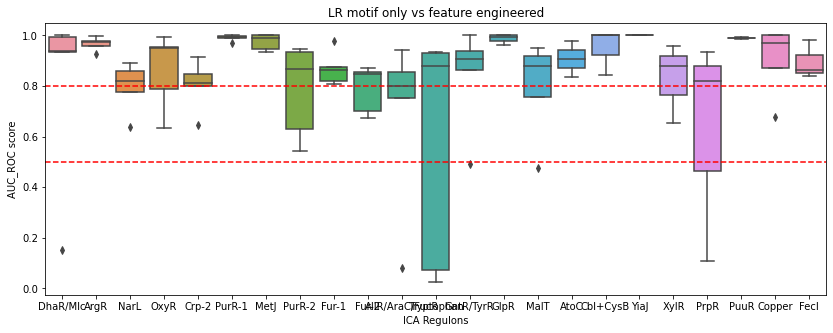

In [58]:
# lot MotifOnly is good enough
plot_df=result_motif[result_motif['im'].isin(motif_enough_list)]

plt.figure( figsize=(14,5))
sns.boxplot(x='im', y='test_auc', data=plot_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.title('LR motif only vs feature engineered')
# plt.xlim([2.5,11.5])
# plt.ylim([0.0,1.05])
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')

plt.savefig('../data/Figures/5fold_MotifOnly_boxplot.pdf')

In [59]:
plot_motif = result_motif[result_motif['im'].isin(im_big_improved)].copy()
plot_all = result_all[result_all['im'].isin(im_big_improved)].copy()
plot_all['Feature type'] = ['Engineered']*plot_all.shape[0]
plot_motif['Feature type'] = ['Motif Only']*plot_motif.shape[0]

plot_df = pd.concat([plot_motif, plot_all],axis=0)

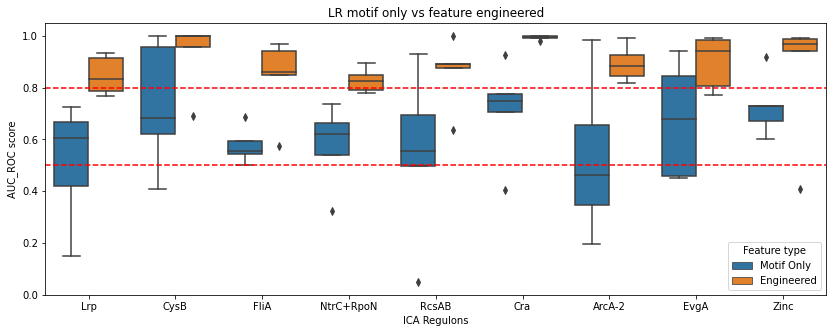

In [60]:
plt.figure( figsize=(14,5))
sns.boxplot(x='im', y='test_auc', hue="Feature type", data=plot_df)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.title('LR motif only vs feature engineered')
plt.xlim([2.5,11.5])
plt.ylim([0.0,1.05])
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')

plt.savefig('../data/Figures/5fold_boxplot.pdf')

In [61]:
# target_no_improved = {}
# for im in im_no_improved:
#     target_no_improved[im] = target_labels[im]
    
# target_big_improved = {}
# for im in im_big_improved:
#     target_big_improved[im] = target_labels[im]

In [62]:
# shap_SMOTETomek(features_table=X_chip_df, path='../data/feature_importance/Big_improved/', suffix = '_SMOTE_MotifOnly', target_labels=target_big_improved)

# shap_SMOTETomek(features_table=X_chip_df, path='../data/feature_importance/No_improved/', suffix = '_SMOTE_MotifOnly', target_labels=target_no_improved)

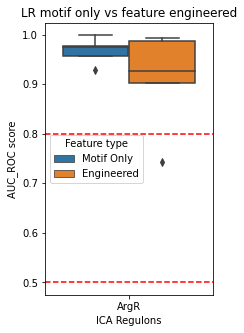

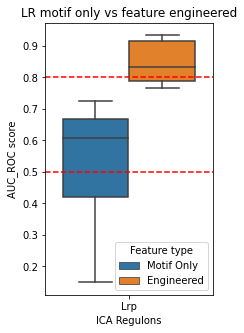

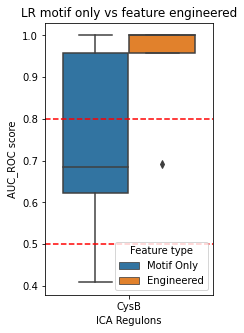

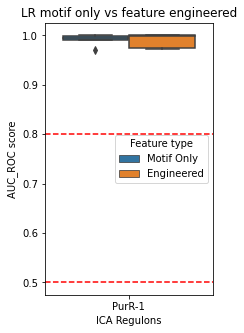

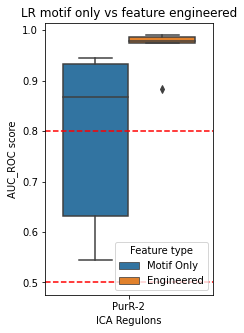

In [63]:
# figure2
temp = {}
temp['ArgR'] = target_labels['ArgR']
temp['Lrp'] = target_labels['Lrp']
temp['CysB'] = target_labels['CysB']

# figure3
temp['PurR-1'] = target_labels['PurR-1']
temp['PurR-2'] = target_labels['PurR-2']

for im in list(temp.keys()):
    plot_motif = result_motif[result_motif['im']==im].copy()
    plot_all = result_all[result_all['im']==im].copy()
    plot_all['Feature type'] = ['Engineered']*plot_all.shape[0]
    plot_motif['Feature type'] = ['Motif Only']*plot_motif.shape[0]

    plot_df = pd.concat([plot_motif, plot_all],axis=0)

    plt.figure( figsize=(3,5))
    sns.boxplot(x='im', y='test_auc', hue="Feature type", data=plot_df)
    plt.axhline(y= 0.5, color = 'r', ls = '--')
    plt.axhline(y= 0.8, color = 'r', ls = '--')
    plt.title('LR motif only vs feature engineered')
    # plt.xlim([2.5,11.5])
    # plt.ylim([0.0,1.05])
    plt.ylabel('AUC_ROC score')
    plt.xlabel('ICA Regulons')

    plt.savefig('../data/Figures/' + im + '_ML_score.pdf')

In [64]:
# Case study feature importance plot
shap_SMOTETomek(features_table=X_chip_df, path='../data/Figures/', suffix = '_SMOTE_MotifOnly.pdf', target_labels=temp)
shap_SMOTETomek(features_table=eng_features_stdd, path='../data/Figures/', suffix = '_SMOTE_all.pdf', target_labels=temp)

ArgR


The max_iter was reached which means the coef_ did not converge


Lrp


The max_iter was reached which means the coef_ did not converge


CysB


The max_iter was reached which means the coef_ did not converge


PurR-1


The max_iter was reached which means the coef_ did not converge


PurR-2


The max_iter was reached which means the coef_ did not converge


ArgR


The max_iter was reached which means the coef_ did not converge


Lrp


The max_iter was reached which means the coef_ did not converge


CysB


The max_iter was reached which means the coef_ did not converge


PurR-1


The max_iter was reached which means the coef_ did not converge


PurR-2


The max_iter was reached which means the coef_ did not converge


<Figure size 432x288 with 0 Axes>

#  7. IM ML status

In [65]:
#load data and delete RF and SVM
nfold_features = pd.read_csv('../data/model_selection_shapeLD_precise1_nfold_SMOTETomek.csv')
#nfold_features = result_all_temp
nfold_features = nfold_features.drop(nfold_features[nfold_features['model'] == 'RF'].index)
nfold_features = nfold_features.drop(nfold_features[nfold_features['model'] == 'SVM'].index)

nfold_MotifOnly = pd.read_csv('../data/model_selection_MotifOnly_precise1_nfold_SMOTETomek.csv')
nfold_MotifOnly = nfold_MotifOnly.drop(nfold_MotifOnly[nfold_MotifOnly['model'] == 'RF'].index)
nfold_MotifOnly = nfold_MotifOnly.drop(nfold_MotifOnly[nfold_MotifOnly['model'] == 'SVM'].index)

nfold_im =[]
for im in nfold_features['im']:
    if im not in nfold_im:
        nfold_im.append(im)

        
        # motif + engineered features score
highest_auc = []
avg_auc = []
med_auc = []
for im in nfold_im:
    highest_auc.append(max(nfold_features[nfold_features['im']==im]['test_auc']))
    avg_auc.append(np.average(nfold_features[nfold_features['im']==im]['test_auc']))
    med_auc.append(np.median(nfold_features[nfold_features['im']==im]['test_auc']))
    
nfold_features_df = pd.DataFrame({'im': nfold_im,
                       'highest_auc': highest_auc,
                       'average_auc': avg_auc,
                       'median_auc': med_auc,},
                      columns=['im','highest_auc','average_auc','median_auc'])

# score for Motif Only
highest_auc_motifONLY = []
avg_auc_motifONLY = []
med_auc_motifONLY = []
for im in nfold_im:
    highest_auc_motifONLY.append(max(nfold_MotifOnly[nfold_MotifOnly['im']==im]['test_auc']))
    avg_auc_motifONLY.append(np.average(nfold_MotifOnly[nfold_MotifOnly['im']==im]['test_auc']))
    med_auc_motifONLY.append(np.median(nfold_MotifOnly[nfold_MotifOnly['im']==im]['test_auc']))
    
nfold_MotifOnly_df = pd.DataFrame({'im': nfold_im,
                       'highest_auc_motifONLY': highest_auc_motifONLY,
                       'average_auc_motifONLY': avg_auc_motifONLY,
                       'median_auc_motifONLY': med_auc_motifONLY,},
                      columns=['im','highest_auc_motifONLY','average_auc_motifONLY','median_auc_motifONLY'])

# iMs that have higher auc score with motif only (before features engineering)
motif_only_iM = []
for im in nfold_im:
    nfold_motifOnly_score = nfold_MotifOnly_df[nfold_MotifOnly_df['im'] == im]['median_auc_motifONLY']
    nfold_score = nfold_features_df[nfold_features_df['im'] == im]['median_auc']
    if nfold_motifOnly_score.values > nfold_score.values:
        motif_only_iM.append(im)
        
#iModulons that include tRNA
tRNA = ['Leu/Ile','Tryptophan','His-tRNA']
#iModulon that does not contain TF
not_tf = ['Thiamine']
#all IModulons that needed to be excluded when building models
IM_toExclude = tRNA + not_tf

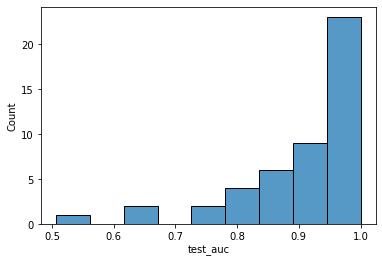

In [66]:
#nfold models with motif only
nfold_with_features = [im for im in nfold_im if im not in motif_only_iM]
nfold_with_features = [im for im in nfold_with_features if im not in IM_toExclude]
result_nfold_with_features = nfold_features_df[(nfold_features_df['im'].isin(nfold_with_features))]
model_with_features = result_nfold_with_features[['im', 'median_auc']]
model_with_features.columns = ['im', 'test_auc']
model_with_features = model_with_features.drop(model_with_features[model_with_features['im']=='PurR-2'].index)
#nfold models with feature engineering
nfold_motifOnly = [im for im in motif_only_iM if im not in IM_toExclude]
result_motifOnly = nfold_MotifOnly_df[(nfold_MotifOnly_df['im'].isin(nfold_motifOnly))]      
model_motifOnly = result_motifOnly[['im','median_auc_motifONLY']]
model_motifOnly.columns = ['im', 'test_auc']
model_result  = pd.concat([model_with_features, model_motifOnly], ignore_index = True, sort = False)
model_result['model'] ='LR'
model_result = model_result.sort_values('test_auc', ascending = False)

# histogram for auc score
sns.histplot(data = model_result, x = 'test_auc')
plt.savefig("../data/Figures/Figure1F_result_histplot.svg")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


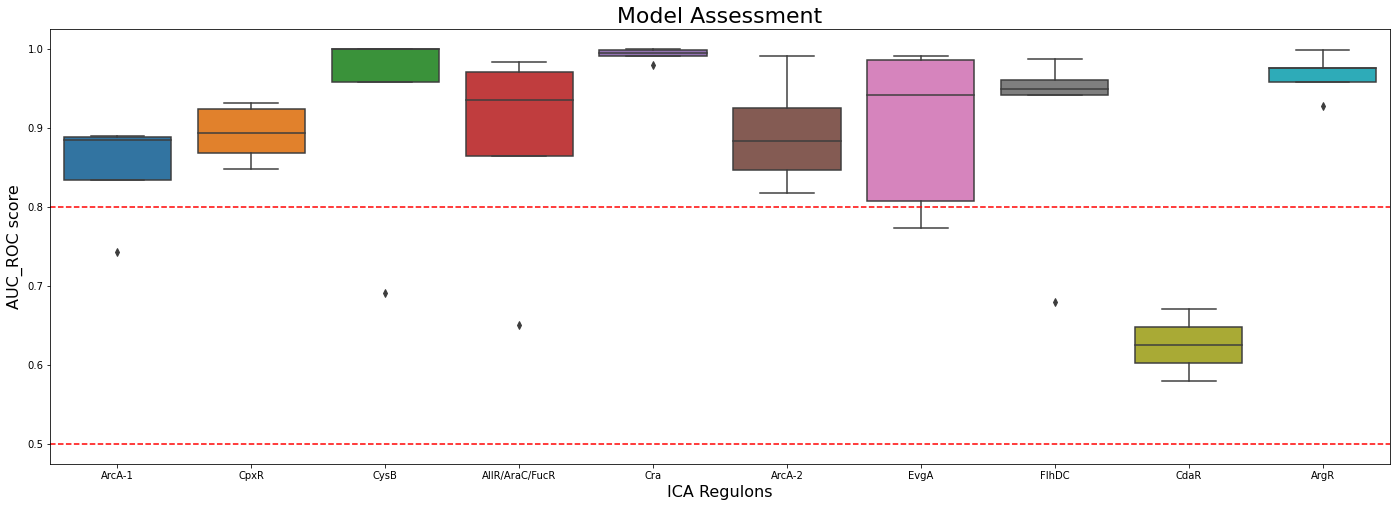

In [67]:
#boxplot for n-fold cv
import matplotlib.font_manager
im_to_try_features = ['AllR/AraC/FucR','ArcA-1', 'ArcA-2','CpxR', 'Cra','EvgA','CysB','FadR','FlhDC','CdaR']
im_to_try_motif = ['ArgR']
nfold_to_try_features = nfold_features[(nfold_features['im'].isin(im_to_try_features))]
nfold_to_try_motif= nfold_MotifOnly[(nfold_MotifOnly['im'].isin(im_to_try_motif))]
nfold_to_try = pd.concat([nfold_to_try_features, nfold_to_try_motif])
plt.figure(figsize=(24,8))
sns.boxplot(x='im', y='test_auc', data=nfold_to_try)
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC_ROC score',fontsize=16)
plt.xlabel('ICA Regulons', fontsize=16)
plt.title('Model Assessment', fontsize= 22)
plt.savefig("../data/Figures/Figure1F_selected_boxplot.svg")


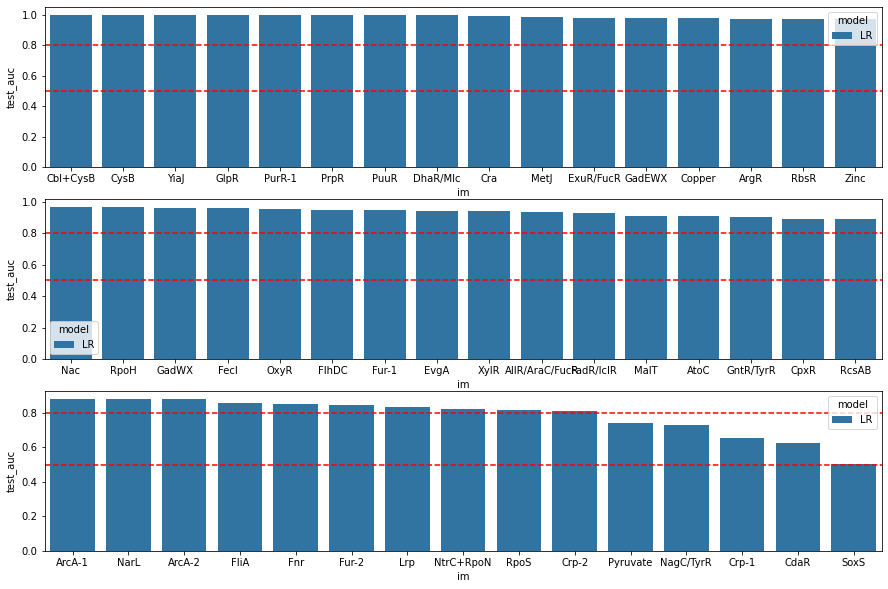

In [68]:
#separated bar graph
#bar graph by performance
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
#divide into three subplots
length = len(model_result)
one_third = round(length/3)
sns.barplot(ax=ax1, x="im", y="test_auc", hue="model", data=model_result[: one_third]) 
ax1.axhline(y= 0.5, color = 'r', ls = '--')
ax1.axhline(y= 0.8, color = 'r', ls = '--')
sns.barplot(ax=ax2, x="im", y="test_auc", hue="model", data=model_result[one_third : (2*one_third)])
ax2.axhline(y= 0.5, color = 'r', ls = '--')
ax2.axhline(y= 0.8, color = 'r', ls = '--')
sns.barplot(ax=ax3, x="im", y="test_auc", hue="model", data=model_result[(2*one_third) :])
ax3.axhline(y= 0.5, color = 'r', ls = '--')
ax3.axhline(y= 0.8, color = 'r', ls = '--')
plt.savefig("../data/Figures/Figure1F_separated_barplot.svg")

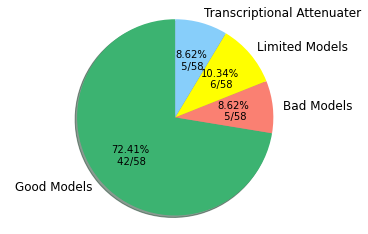

In [69]:
#limited iModulons
one_promoters = ['GlcC', 'CecR', 'SrlR+GutM', 'NikR', 'GcvA']
no_TSS=['CsqR']
limited = len(one_promoters) + len(no_TSS)

#pie chart
labels =['Good Models', 'Bad Models','Limited Models','Transcriptional Attenuater']
a = sum(model_result['test_auc']>0.8)
b = sum((model_result['test_auc']>0.5) & (model_result['test_auc']<0.8))
c = limited
# '+1' for PurR-2
d = len(tRNA) + len(not_tf)+1
sizes = np.array([a,b,c,d])
fig1, ax1 = plt.subplots()
wedges, texts, autotexts, = ax1.pie(sizes, labels=labels, autopct=lambda p:f'{p:.2f}%\n {p*sum(sizes)/100 :.0f}/58',
        shadow=True, startangle=90, colors =['mediumseagreen','salmon', 'yellow','lightskyblue'], textprops={'color':"k"})
ax1.axis('equal') 
texts[0].set_fontsize(12)
texts[1].set_fontsize(12)
texts[2].set_fontsize(12)
texts[3].set_fontsize(12)
plt.savefig("../data/Figures/Figure1F_result_pie_chart.svg")

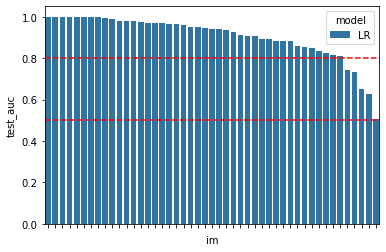

In [70]:
# bar graph for all
all_bar = sns.barplot(x="im", y="test_auc", hue = 'model', data=model_result) 
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
all_bar.set(xticklabels = [])
plt.savefig("../data/Figures/Figure1F_all_barplot.svg")

## Feature importance overview

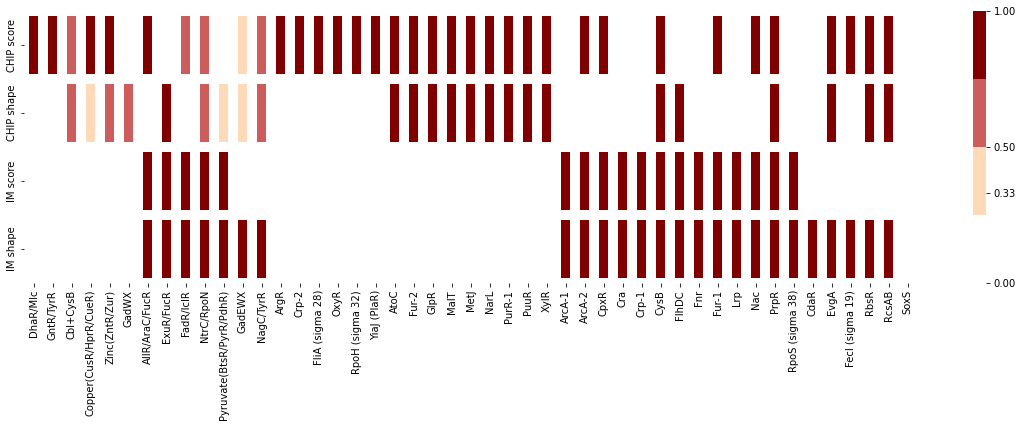

In [71]:
fig, ax = plt.subplots(1,1,figsize= (20,5))
features_df1 = pd.read_csv("../data/firstfive_features_multi.csv",index_col=0).T
features_df2 = pd.read_csv("../data/firstfive_features_single.csv", index_col=0).T
features_df = pd.concat([features_df1, features_df2], axis=1)
# features_df = features_df.replace(2.3, 2.9)
# features_df = features_df.replace(2.5, 3.9)
# features_df = features_df.replace(3, 4.9)
f = sns.heatmap(features_df, ax=ax, linewidths=10, cmap=['white', 'peachpuff', 'indianred', 'maroon'],cbar_kws={'ticks':[0,0.33,0.5,1.0]},)

# f.set_yticks([0, 0.5, 1])
# f.set_yticklabels(["Doesn't exist", "Patially exist", "Exist"],fontsize=16, fontweight=2)

In [72]:
fig.savefig('../data/Figures/features_count.svg')

In [73]:
import re
median_diff = pd.DataFrame(columns=['median_eng', 'median_MotifOnly', 'median_diff'])
for im in features_df.columns:
    if im == 'NtrC/RpoN':
        im = 'NtrC+RpoN'
#     if im =='PurR-2':
#         continue
    im=re.sub("\(.*?\)","", im)
    im = im.replace(' ', '')
    diff = nfold_features[nfold_features['im']==im]['test_auc'].mean() - nfold_MotifOnly[nfold_MotifOnly['im']==im]['test_auc'].mean()
    if diff < 0:
        median_diff.loc[im, 'median_diff'] = 0
    else:
        median_diff.loc[im, 'median_diff'] = diff
    median_diff.loc[im, 'median_eng'] = nfold_features[nfold_features['im']==im]['test_auc'].mean()
    median_diff.loc[im, 'median_MotifOnly'] = nfold_MotifOnly[nfold_MotifOnly['im']==im]['test_auc'].mean()

median_diff.to_csv('../data/auc_median_result.csv')

median_diff['im'] = median_diff.index

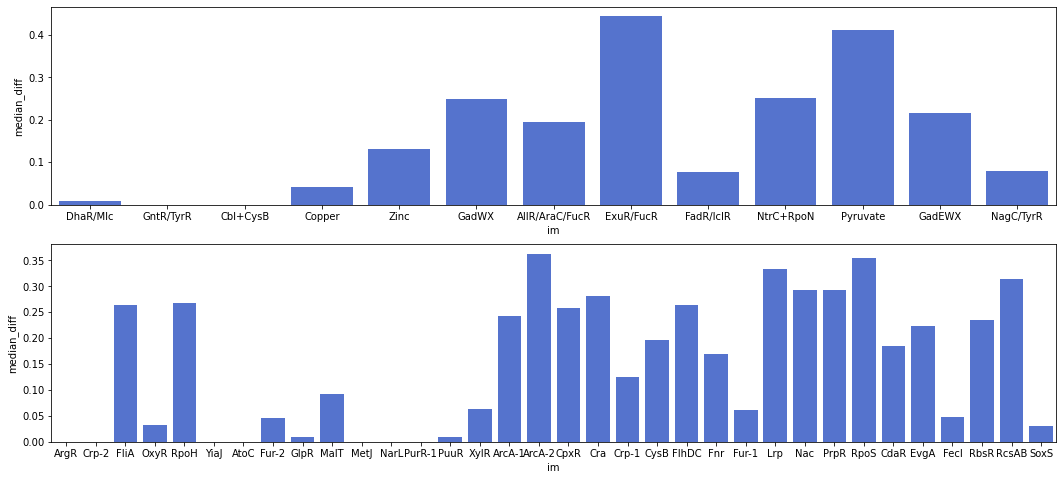

In [74]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize= (18,8))
f1 = sns.barplot(data=median_diff.iloc[:13,:], x='im', y='median_diff', ax=ax1,color='royalblue')
f2 = sns.barplot(data=median_diff.iloc[13:,:], x='im', y='median_diff', ax=ax2,color='royalblue')

In [75]:
fig.savefig('../data/Figures/median_diff.pdf')

<AxesSubplot:>

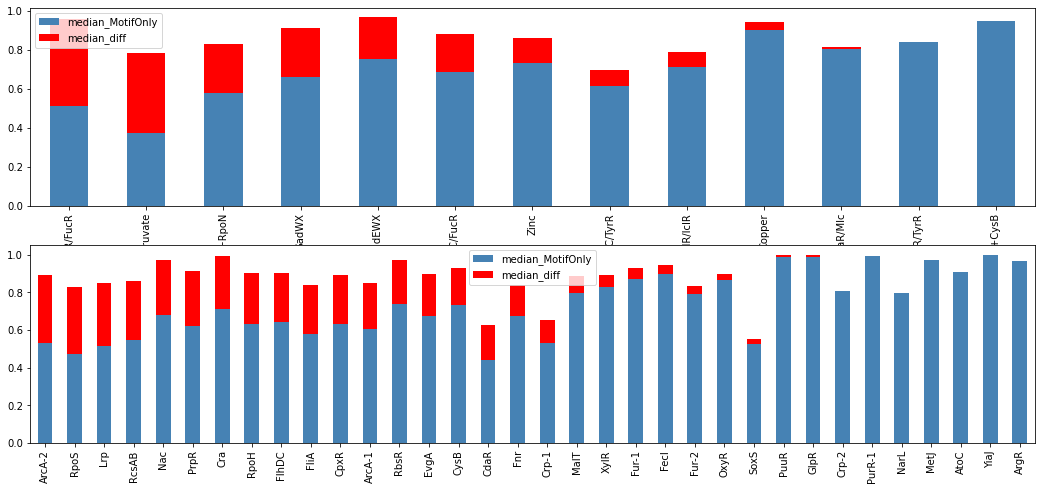

In [76]:
temp = median_diff.loc[:, ['median_MotifOnly', 'median_diff']].copy()

fig, (ax1,ax2) = plt.subplots(2,1,figsize= (18,8))

temp.iloc[:13,:].sort_values(by='median_diff',ascending=False).plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax1)
temp.iloc[13:,:].sort_values(by='median_diff',ascending=False).plot(kind='bar', stacked=True, color=['steelblue', 'red'], ax=ax2)

In [77]:
fig.savefig('../data/Figures/median_diff_stacked.pdf')

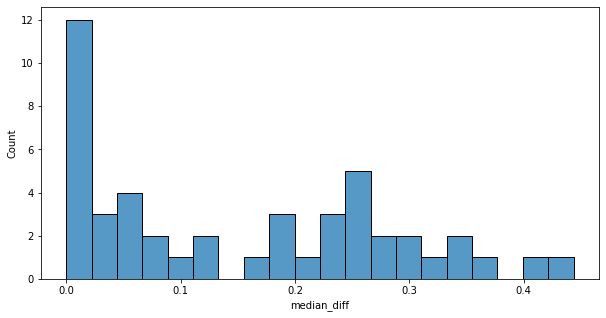

In [78]:
fig, ax1 = plt.subplots(1,1,figsize= (10,5))

sns.histplot(data=median_diff, x='median_diff', bins=20)

fig.savefig('../data/Figures/median_diff_hist.pdf')

In [79]:
plot_df=nfold_features.copy()
plot_df = plot_df[~plot_df['im'].isin(['Thiamine', 'Tryptophan', 'PurR-2', 'His-tRNA', 'Leu/Ile'])]
plot_df = plot_df.reset_index()

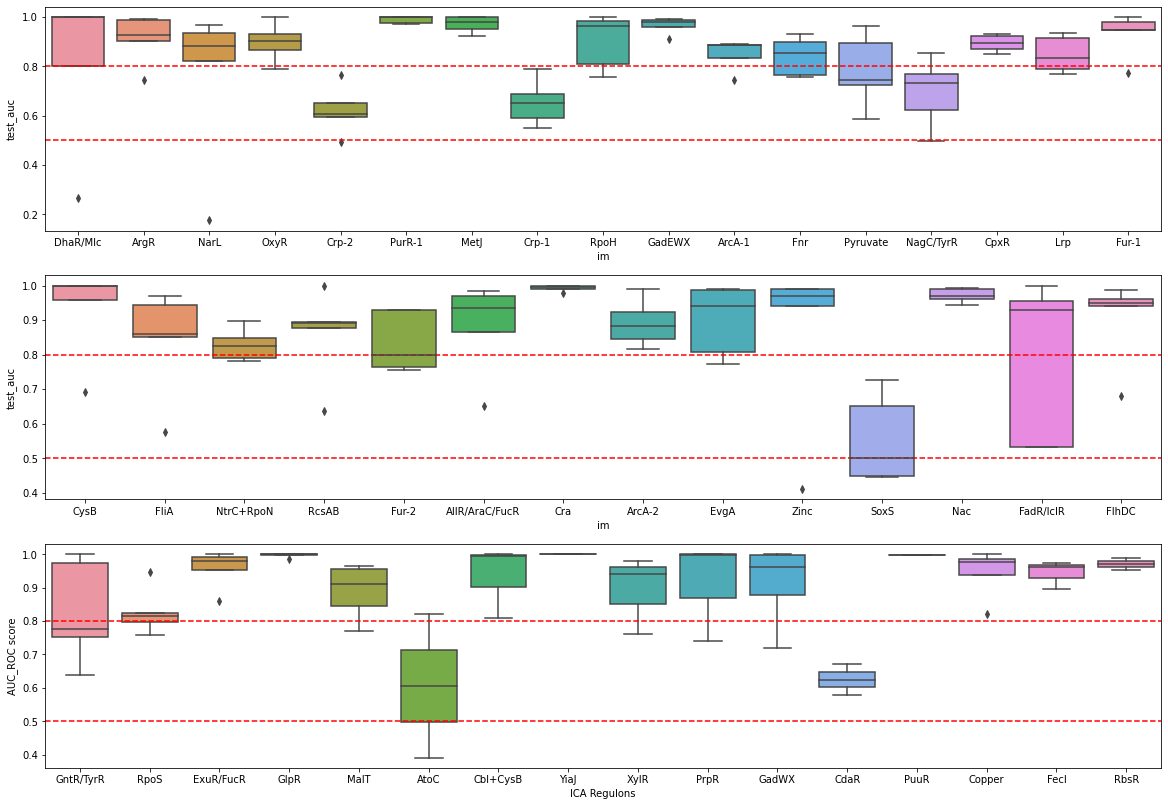

In [80]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,14))
f1 = sns.boxplot(x='im', y='test_auc', data=plot_df[:85], ax=ax1)
ax1.axhline(y= 0.5, color = 'r', ls = '--')
ax1.axhline(y= 0.8, color = 'r', ls = '--')
f2 = sns.boxplot(x='im', y='test_auc', data=plot_df[85:155], ax=ax2)
ax2.axhline(y= 0.5, color = 'r', ls = '--')
ax2.axhline(y= 0.8, color = 'r', ls = '--')
f3 = sns.boxplot(x='im', y='test_auc', data=plot_df[155:], ax=ax3)
ax3.axhline(y= 0.5, color = 'r', ls = '--')
ax3.axhline(y= 0.8, color = 'r', ls = '--')

# plt.xlim([2.5,11.5])
# plt.ylim([0.0,1.05])
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')

plt.savefig('../data/Figures/5fold_Features_boxplot_all.pdf')

##### plot_motif = nfold_MotifOnly.copy()
plot_motif = plot_motif[~plot_motif['im'].isin(['Thiamine', 'Tryptophan', 'PurR-2', 'His-tRNA', 'Leu/Ile'])]
plot_motif = plot_motif.reset_index()

plot_all = nfold_features.copy()
plot_all = plot_all[~plot_all['im'].isin(['Thiamine', 'Tryptophan', 'PurR-2', 'His-tRNA', 'Leu/Ile'])]
plot_all = plot_all.reset_index()

plot_all['Feature type'] = ['Engineered']*plot_all.shape[0]
plot_motif['Feature type'] = ['Motif Only']*plot_motif.shape[0]

plot_df = pd.concat([plot_motif[:85], plot_all[:85]],axis=0)
plot_df = pd.concat([plot_df, plot_motif[85:155], plot_all[85:155]],axis=0)
plot_df = pd.concat([plot_df, plot_motif[155:], plot_all[155:]],axis=0)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,14))
f1 = sns.boxplot(x='im', y='test_auc', hue='Feature type', data=plot_df[:170], ax=ax1, width=0.8)
ax1.axhline(y= 0.5, color = 'r', ls = '--')
ax1.axhline(y= 0.8, color = 'r', ls = '--')
f2 = sns.boxplot(x='im', y='test_auc', hue = 'Feature type', data=plot_df[170:310], ax=ax2, width=0.8)
ax2.axhline(y= 0.5, color = 'r', ls = '--')
ax2.axhline(y= 0.8, color = 'r', ls = '--')
f3 = sns.boxplot(x='im', y='test_auc', hue = 'Feature type', data=plot_df[310:], ax=ax3, width=0.8)
ax3.axhline(y= 0.5, color = 'r', ls = '--')
ax3.axhline(y= 0.8, color = 'r', ls = '--')

# plt.xlim([2.5,11.5])
# plt.ylim([0.0,1.05])
plt.ylabel('AUC_ROC score')
plt.xlabel('ICA Regulons')

plt.savefig('../data/Figures/5fold_Compare_boxplot_all.pdf')